### Notebook for the GRN inference on COPD - CTRL using `cellroacle`

- **Developed by**: Carlos Talavera-López Ph.D
- **Institute of Computational Biology - Computational Health Centre - Helmholtz Munich**
- v230622

### Import required libraries

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

import celloracle as co
co.__version__

INFO:matplotlib.font_manager:Failed to extract font properties from /System/Library/Fonts/LastResort.otf: tuple indices must be integers or slices, not str
INFO:matplotlib.font_manager:Failed to extract font properties from /System/Library/Fonts/Apple Color Emoji.ttc: In FT2Font: Could not set the fontsize (invalid pixel size; error code 0x17)
INFO:matplotlib.font_manager:Failed to extract font properties from /System/Library/Fonts/Supplemental/NISC18030.ttf: In FT2Font: Could not set the fontsize (invalid pixel size; error code 0x17)


'0.12.0'

In [2]:
save_folder = "figures"
os.makedirs(save_folder, exist_ok = True)

- Set up working environment

In [3]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = (15,7)
plt.rcParams["savefig.dpi"] = 600

### Load datasets

In [4]:
BrEpit_mixed = sc.read_h5ad('../../../data/Epithelial_Mixed_ctl230608_states.raw.h5ad') 
BrEpit_mixed

AnnData object with n_obs × n_vars = 12256 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', '_scvi_batch', '_scvi_labels', 'IAV_score', 'group', 'C_scANVI', 'cell_type', 'leiden', 'leiden_states', 'seed_labels', 'Viral_score', 'C_scANVI_v2', 'mixed_states'
    var: 'mt', 'ribo', 'n_cells_by_counts-V1', 'mean_counts-V1', 'pct_dropout_by_counts-V1', 'total_counts-V1', 'n_cells_by_counts-V2', 'mean_counts-V2', 'pct_dropout_by_counts-V2', 'total_counts-V2', 'n_cells_by_counts-V3', 'mean_counts-V3', 'pct_dropout_by_counts-V3', 'total_counts-V3', 'n_cells_by_counts-V4', 'mean_counts-V4', 'pct_dropout_by_counts-V4', 'total_counts-V4', '

In [5]:
print(f"Cell number is :{BrEpit_mixed.shape[0]}")
print(f"Gene number is :{BrEpit_mixed.shape[1]}")

Cell number is :12256
Gene number is :27208


### Subset condition of interest

In [6]:
BrEpit_mixed.obs['group'].value_counts()

copd_iav        6164
healthy_iav     4104
copd_ctrl       1271
healthy_ctrl     717
Name: group, dtype: int64

In [7]:
adata = BrEpit_mixed[BrEpit_mixed.obs['group'].isin(['copd_ctrl'])]
adata

View of AnnData object with n_obs × n_vars = 1271 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', '_scvi_batch', '_scvi_labels', 'IAV_score', 'group', 'C_scANVI', 'cell_type', 'leiden', 'leiden_states', 'seed_labels', 'Viral_score', 'C_scANVI_v2', 'mixed_states'
    var: 'mt', 'ribo', 'n_cells_by_counts-V1', 'mean_counts-V1', 'pct_dropout_by_counts-V1', 'total_counts-V1', 'n_cells_by_counts-V2', 'mean_counts-V2', 'pct_dropout_by_counts-V2', 'total_counts-V2', 'n_cells_by_counts-V3', 'mean_counts-V3', 'pct_dropout_by_counts-V3', 'total_counts-V3', 'n_cells_by_counts-V4', 'mean_counts-V4', 'pct_dropout_by_counts-V4', 'total_counts

In [8]:
print(f"Cell number is :{adata.shape[0]}")
print(f"Gene number is :{adata.shape[1]}")

Cell number is :1271
Gene number is :27208


In [9]:
print(f"Cell number is :{adata.shape[0]}")

Cell number is :1271


### Reduce the inference workload by select HVGs

In [10]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 3000,
    layer = "counts",
    batch_key = "donor",
    subset = True
)

adata

AnnData object with n_obs × n_vars = 1271 × 3000
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', '_scvi_batch', '_scvi_labels', 'IAV_score', 'group', 'C_scANVI', 'cell_type', 'leiden', 'leiden_states', 'seed_labels', 'Viral_score', 'C_scANVI_v2', 'mixed_states'
    var: 'mt', 'ribo', 'n_cells_by_counts-V1', 'mean_counts-V1', 'pct_dropout_by_counts-V1', 'total_counts-V1', 'n_cells_by_counts-V2', 'mean_counts-V2', 'pct_dropout_by_counts-V2', 'total_counts-V2', 'n_cells_by_counts-V3', 'mean_counts-V3', 'pct_dropout_by_counts-V3', 'total_counts-V3', 'n_cells_by_counts-V4', 'mean_counts-V4', 'pct_dropout_by_counts-V4', 'total_counts-V4', 'n_

### Load base GRN

In [11]:
peaks = pd.read_parquet("Epithelial_lung_base_GRN_dataframe.parquet")
peaks.head()

peak_id gene_short_name  9430076C15Rik  AC002126.6  \
0  chr10_100346875_100347053             SCD            0.0         0.0   
1  chr10_100346947_100347161             SCD            0.0         0.0   
2  chr10_100347087_100347438             SCD            0.0         0.0   
3  chr10_100372680_100372946        OLMALINC            0.0         0.0   
4  chr10_101130776_101130905          TLX1NB            0.0         0.0   

   AC012531.1  AC226150.2  AFP  AHR  AHRR  AIRE  ...  Znf431  Zscan10  \
0         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0      0.0   
1         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0      0.0   
2         0.0         0.0  0.0  1.0   1.0   0.0  ...     0.0      0.0   
3         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0      0.0   
4         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0      0.0   

   Zscan26  Zscan4  arnt  cMyc  cebpa  nMyc  p53  p63  
0      0.0     0.0   0.0   0.0    0.0   0.0  0.0  0.0  
1      0.0     0.0   0.0   0.0    0.0   0.0  0.0  0.0  
2      0.0     0.0   1.0   0.0    0.0   0.0  0.0  0.0  
3      0.0     0.0   0.0   0.0    0.0   0.0  0.0  0.0  
4      0.0     0.0   0.0   0.0    0.0   0.0  0.0  0.0  

[5 rows x 1718 columns]

### Make Oracle object

In [12]:
oracle = co.Oracle()

In [13]:
print("Metadata columns :", list(adata.obs.columns))
print("Dimensional reduction: ", list(adata.obsm.keys()))

Metadata columns : ['sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', '_scvi_batch', '_scvi_labels', 'IAV_score', 'group', 'C_scANVI', 'cell_type', 'leiden', 'leiden_states', 'seed_labels', 'Viral_score', 'C_scANVI_v2', 'mixed_states']
Dimensional reduction:  ['X_pca', 'X_scANVI', 'X_scVI', 'X_umap']


In [14]:
oracle.import_anndata_as_raw_count(adata = adata,
                                   cluster_column_name = "mixed_states",
                                   embedding_name = "X_scANVI")

In [15]:
oracle.import_TF_data(TF_info_matrix = peaks)

### KNN imputation

In [16]:
oracle.perform_PCA()

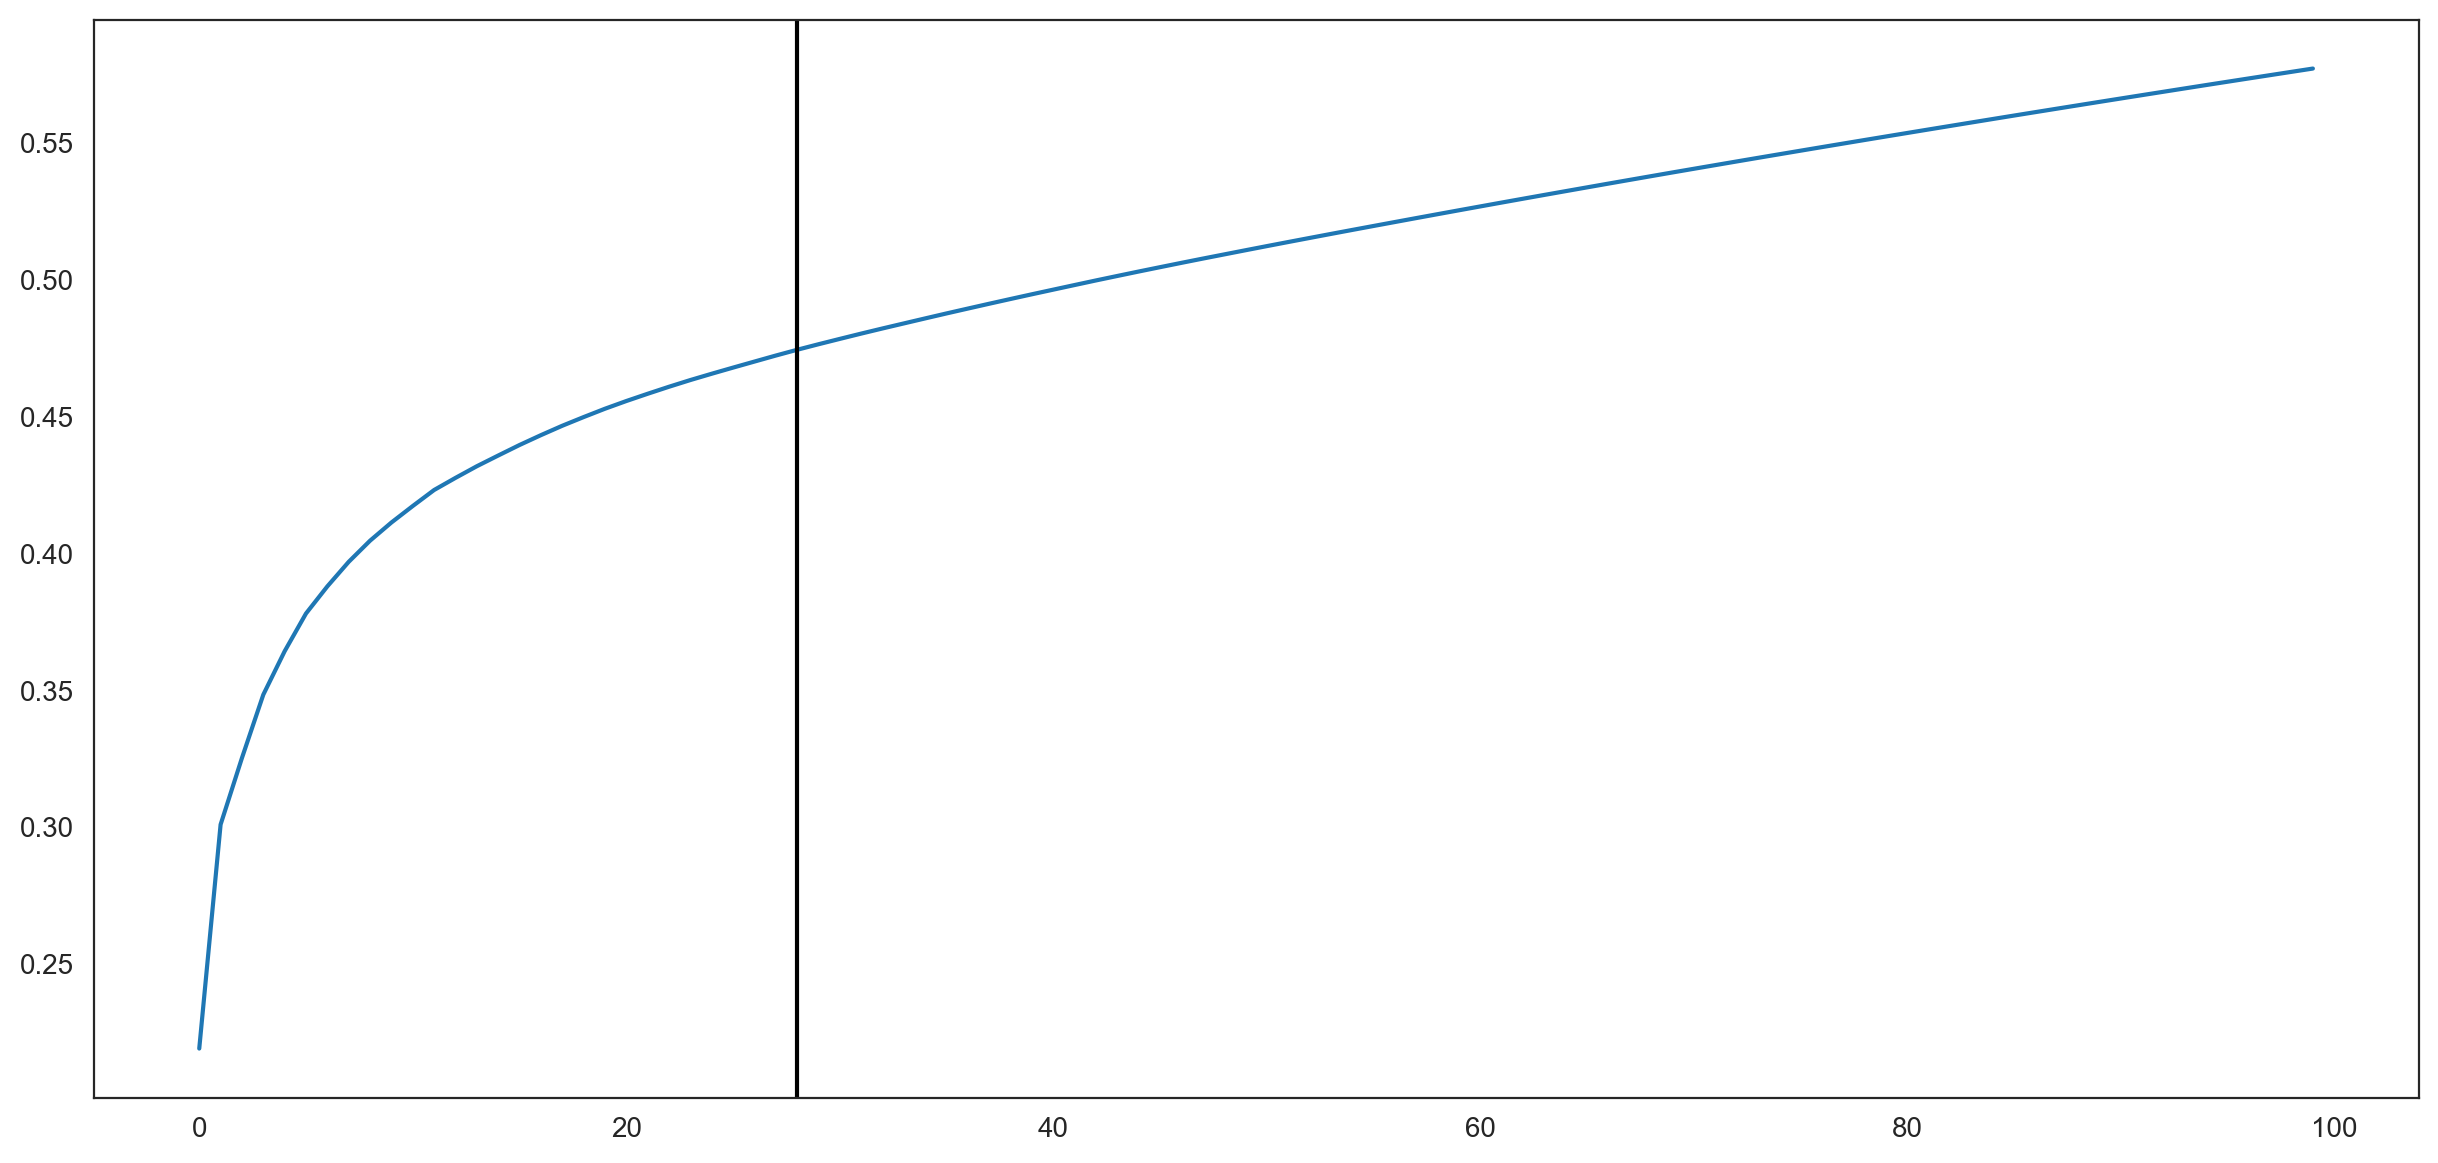

28


In [17]:
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c = "k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

- Estimate the optimal number of nearest neighbors for KNN imputation.

In [18]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

cell number is :1271


In [19]:
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

Auto-selected k is :31


In [20]:
oracle.knn_imputation(n_pca_dims = n_comps, k = k, balanced = True, b_sight = k*8,
                      b_maxl = k*4, n_jobs = 4)

-  Save and Load

### GRN calculation

In [21]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.8.0
scanpy      1.9.3
-----
Bio                 1.81
PIL                 9.2.0
appdirs             1.4.4
appnope             0.1.3
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
biothings_client    0.3.0
brotli              NA
celloracle          0.12.0
certifi             2022.12.07
cffi                1.15.1
charset_normalizer  2.1.1
colorama            0.4.6
comm                0.1.3
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.6
decorator           5.1.1
defusedxml          0.7.1
diskcache           5.4.0
executing           1.2.0
filelock            3.10.2
genomepy            0.15.0
gimmemotifs         0.17.0
goatools            1.3.1
google              NA
h5py                3.8.0
hypergeom_ufunc     NA
idna                3.4
igraph              0.10.4
invgauss_ufunc      NA
ipykernel           6.22.0
ipython_genutils    0.2.0
ipywidgets          8.0.5
iter

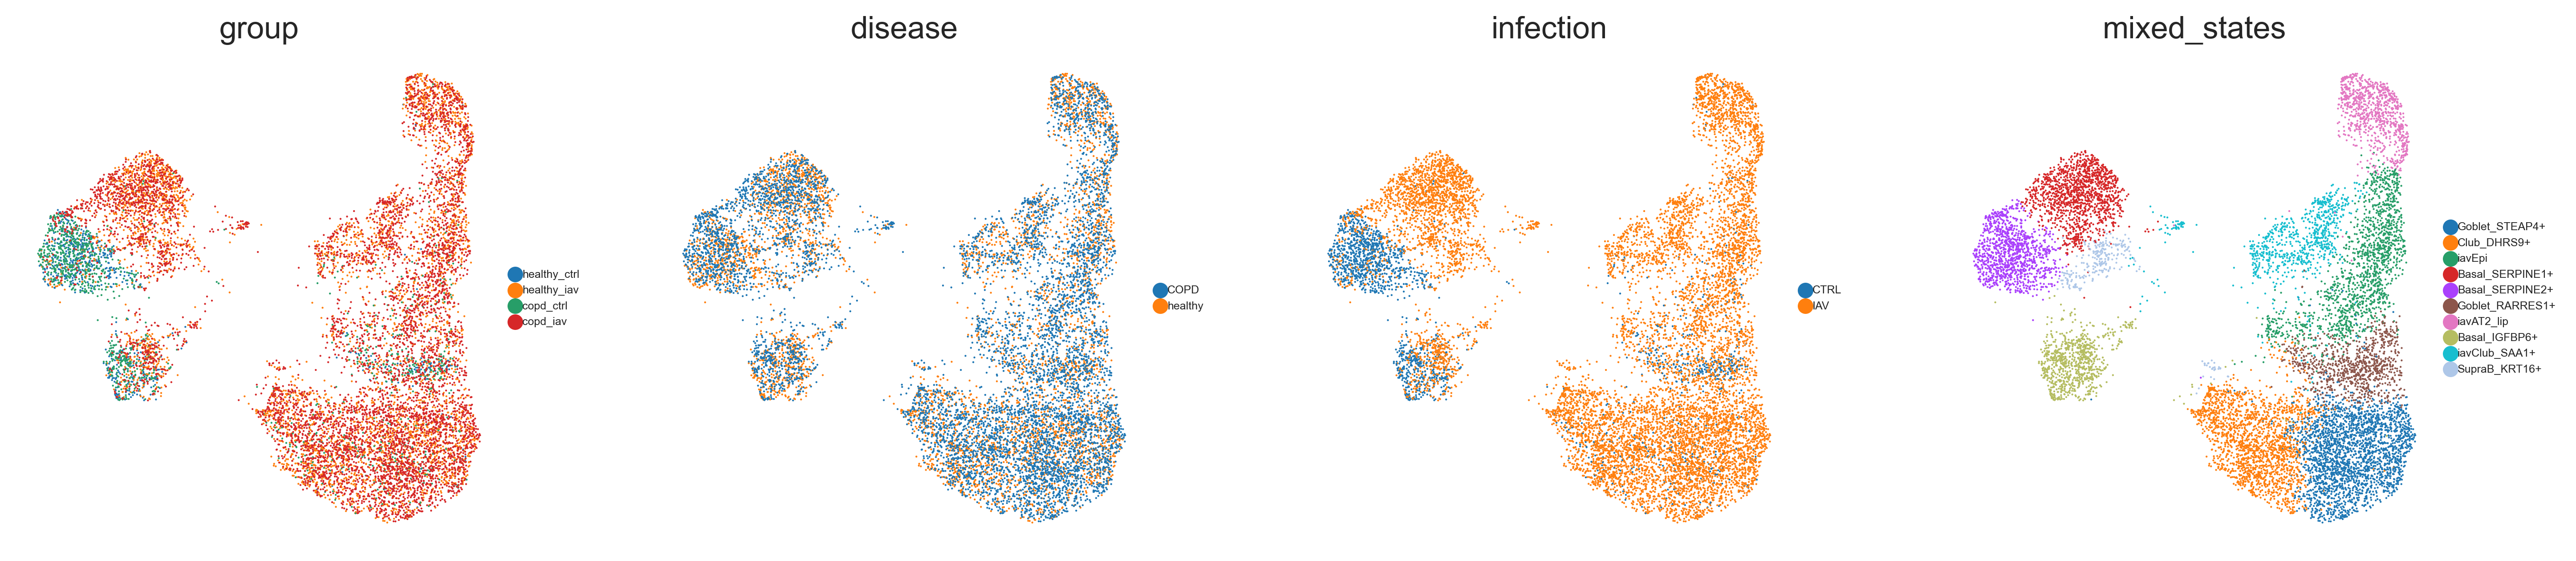

In [23]:
sc.pl.umap(BrEpit_mixed, frameon = False, color = ['group', 'disease', 'infection', 'mixed_states'], size = 3, legend_fontsize = 5, ncols = 4)

In [24]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = (15,7)
plt.rcParams["savefig.dpi"] = 600

In [25]:
%%time
links = oracle.get_links(cluster_name_for_GRN_unit = "mixed_states", alpha = 10,
                         verbose_level = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Inferring GRN for Basal_IGFBP6+...


  0%|          | 0/500 [00:00<?, ?it/s]

Inferring GRN for Basal_SERPINE1+...


  0%|          | 0/500 [00:00<?, ?it/s]

Inferring GRN for Basal_SERPINE2+...


  0%|          | 0/500 [00:00<?, ?it/s]

Inferring GRN for Club_DHRS9+...


  0%|          | 0/500 [00:00<?, ?it/s]

Inferring GRN for Goblet_RARRES1+...


  0%|          | 0/500 [00:00<?, ?it/s]

Inferring GRN for Goblet_STEAP4+...


  0%|          | 0/500 [00:00<?, ?it/s]

Inferring GRN for SupraB_KRT16+...


  0%|          | 0/500 [00:00<?, ?it/s]

Inferring GRN for iavAT2_lip...


  0%|          | 0/500 [00:00<?, ?it/s]

/Users/cartalop/mambaforge/envs/celloracle/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Inferring GRN for iavClub_SAA1+...


  0%|          | 0/500 [00:00<?, ?it/s]

Inferring GRN for iavEpi...


  0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 1min 50s, sys: 4.2 s, total: 1min 54s
Wall time: 2min 48s


In [26]:
links.links_dict.keys()

dict_keys(['Basal_IGFBP6+', 'Basal_SERPINE1+', 'Basal_SERPINE2+', 'Club_DHRS9+', 'Goblet_RARRES1+', 'Goblet_STEAP4+', 'SupraB_KRT16+', 'iavAT2_lip', 'iavClub_SAA1+', 'iavEpi'])

In [27]:
links.links_dict["Basal_SERPINE2+"]

source  target  coef_mean  coef_abs             p      -logp
0       RARG   ABCC5   0.080105  0.080105  1.825429e-11  10.738635
1       ESR1   ABCC5   0.044916  0.044916  1.250144e-09   8.903040
2     POU2F3    ABT1   0.004802  0.004802  9.702390e-07   6.013121
3       LHX5    ABT1   0.012335  0.012335  1.115043e-08   7.952708
4     ARID3B    ABT1  -0.004036  0.004036  2.880281e-02   1.540565
...      ...     ...        ...       ...           ...        ...
7309   NR4A2  ZNF75D  -0.008664  0.008664  2.193679e-03   2.658827
7310    ETS1  ZNF75D   0.000934  0.000934  7.790541e-01   0.108432
7311    JUNB  ZNF75D  -0.011802  0.011802  1.154180e-05   4.937726
7312   FOSL1  ZNF75D  -0.039712  0.039712  6.240729e-13  12.204765
7313    FOSB  ZNF75D   0.028505  0.028505  1.223493e-07   6.912399

[7314 rows x 6 columns]

### Network preprocessing

In [28]:
links.filter_links(p = 0.001, weight = "coef_abs", threshold_number = 2000)

Basal_IGFBP6+


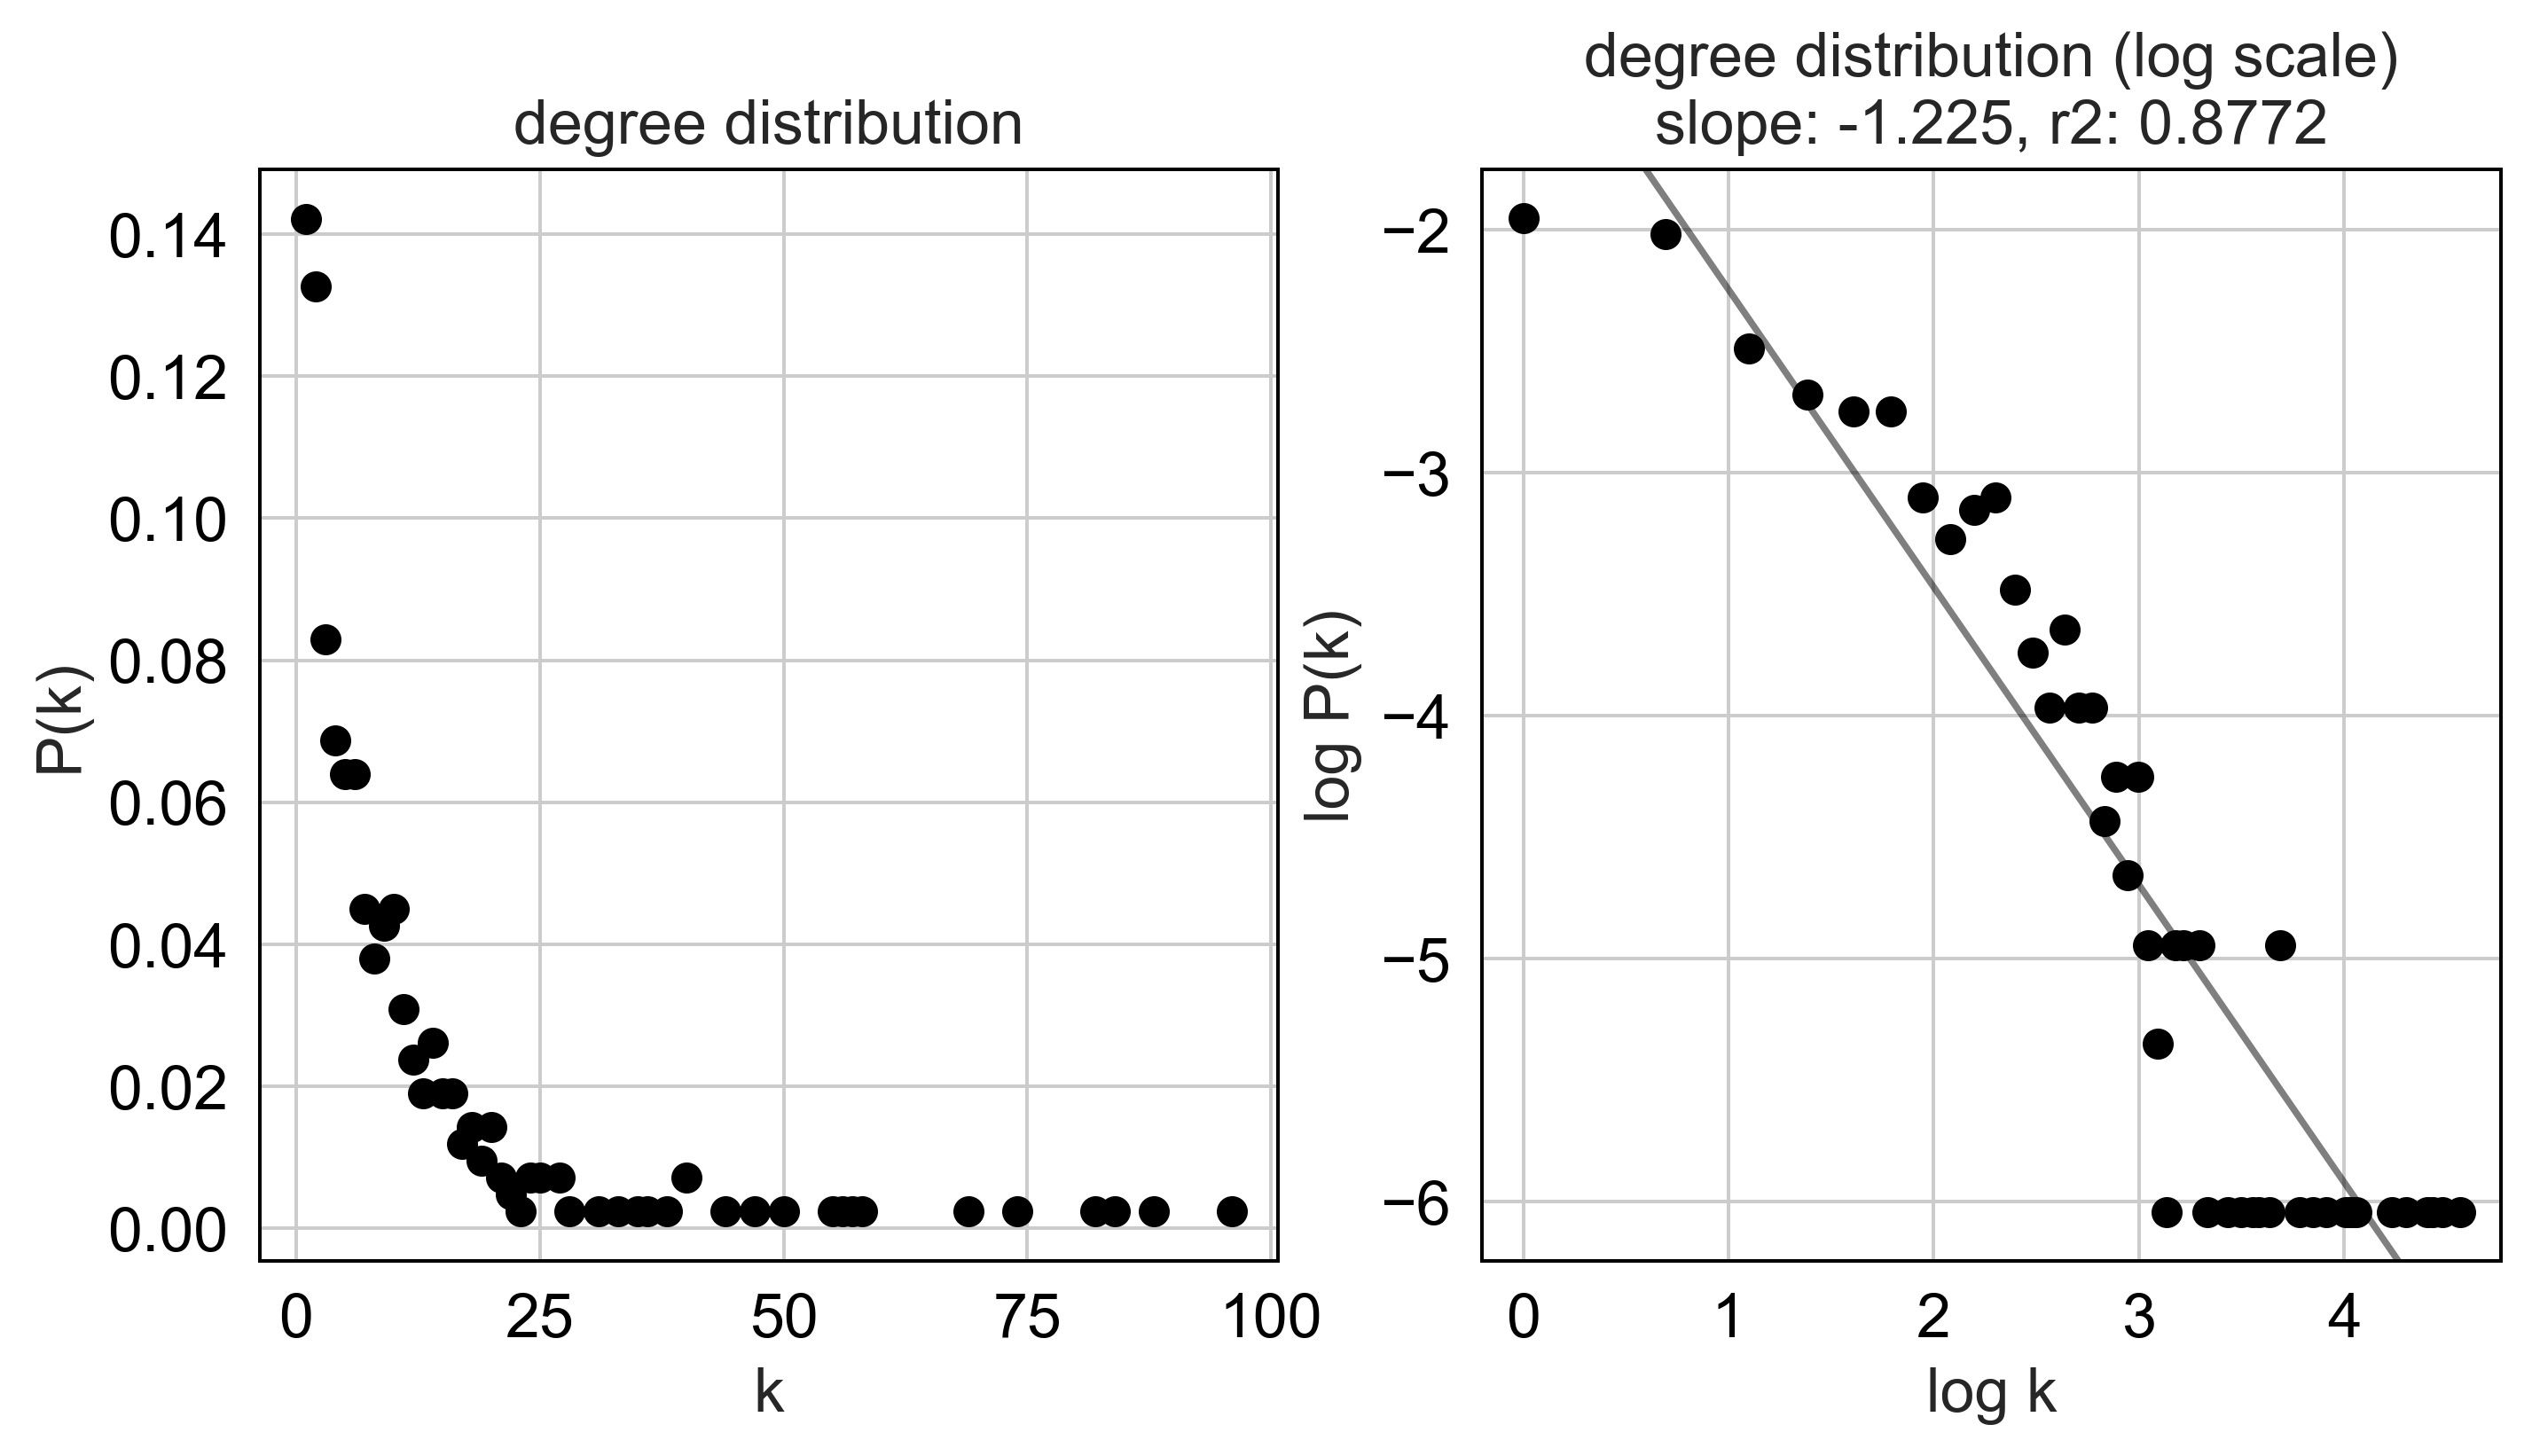

Basal_SERPINE1+


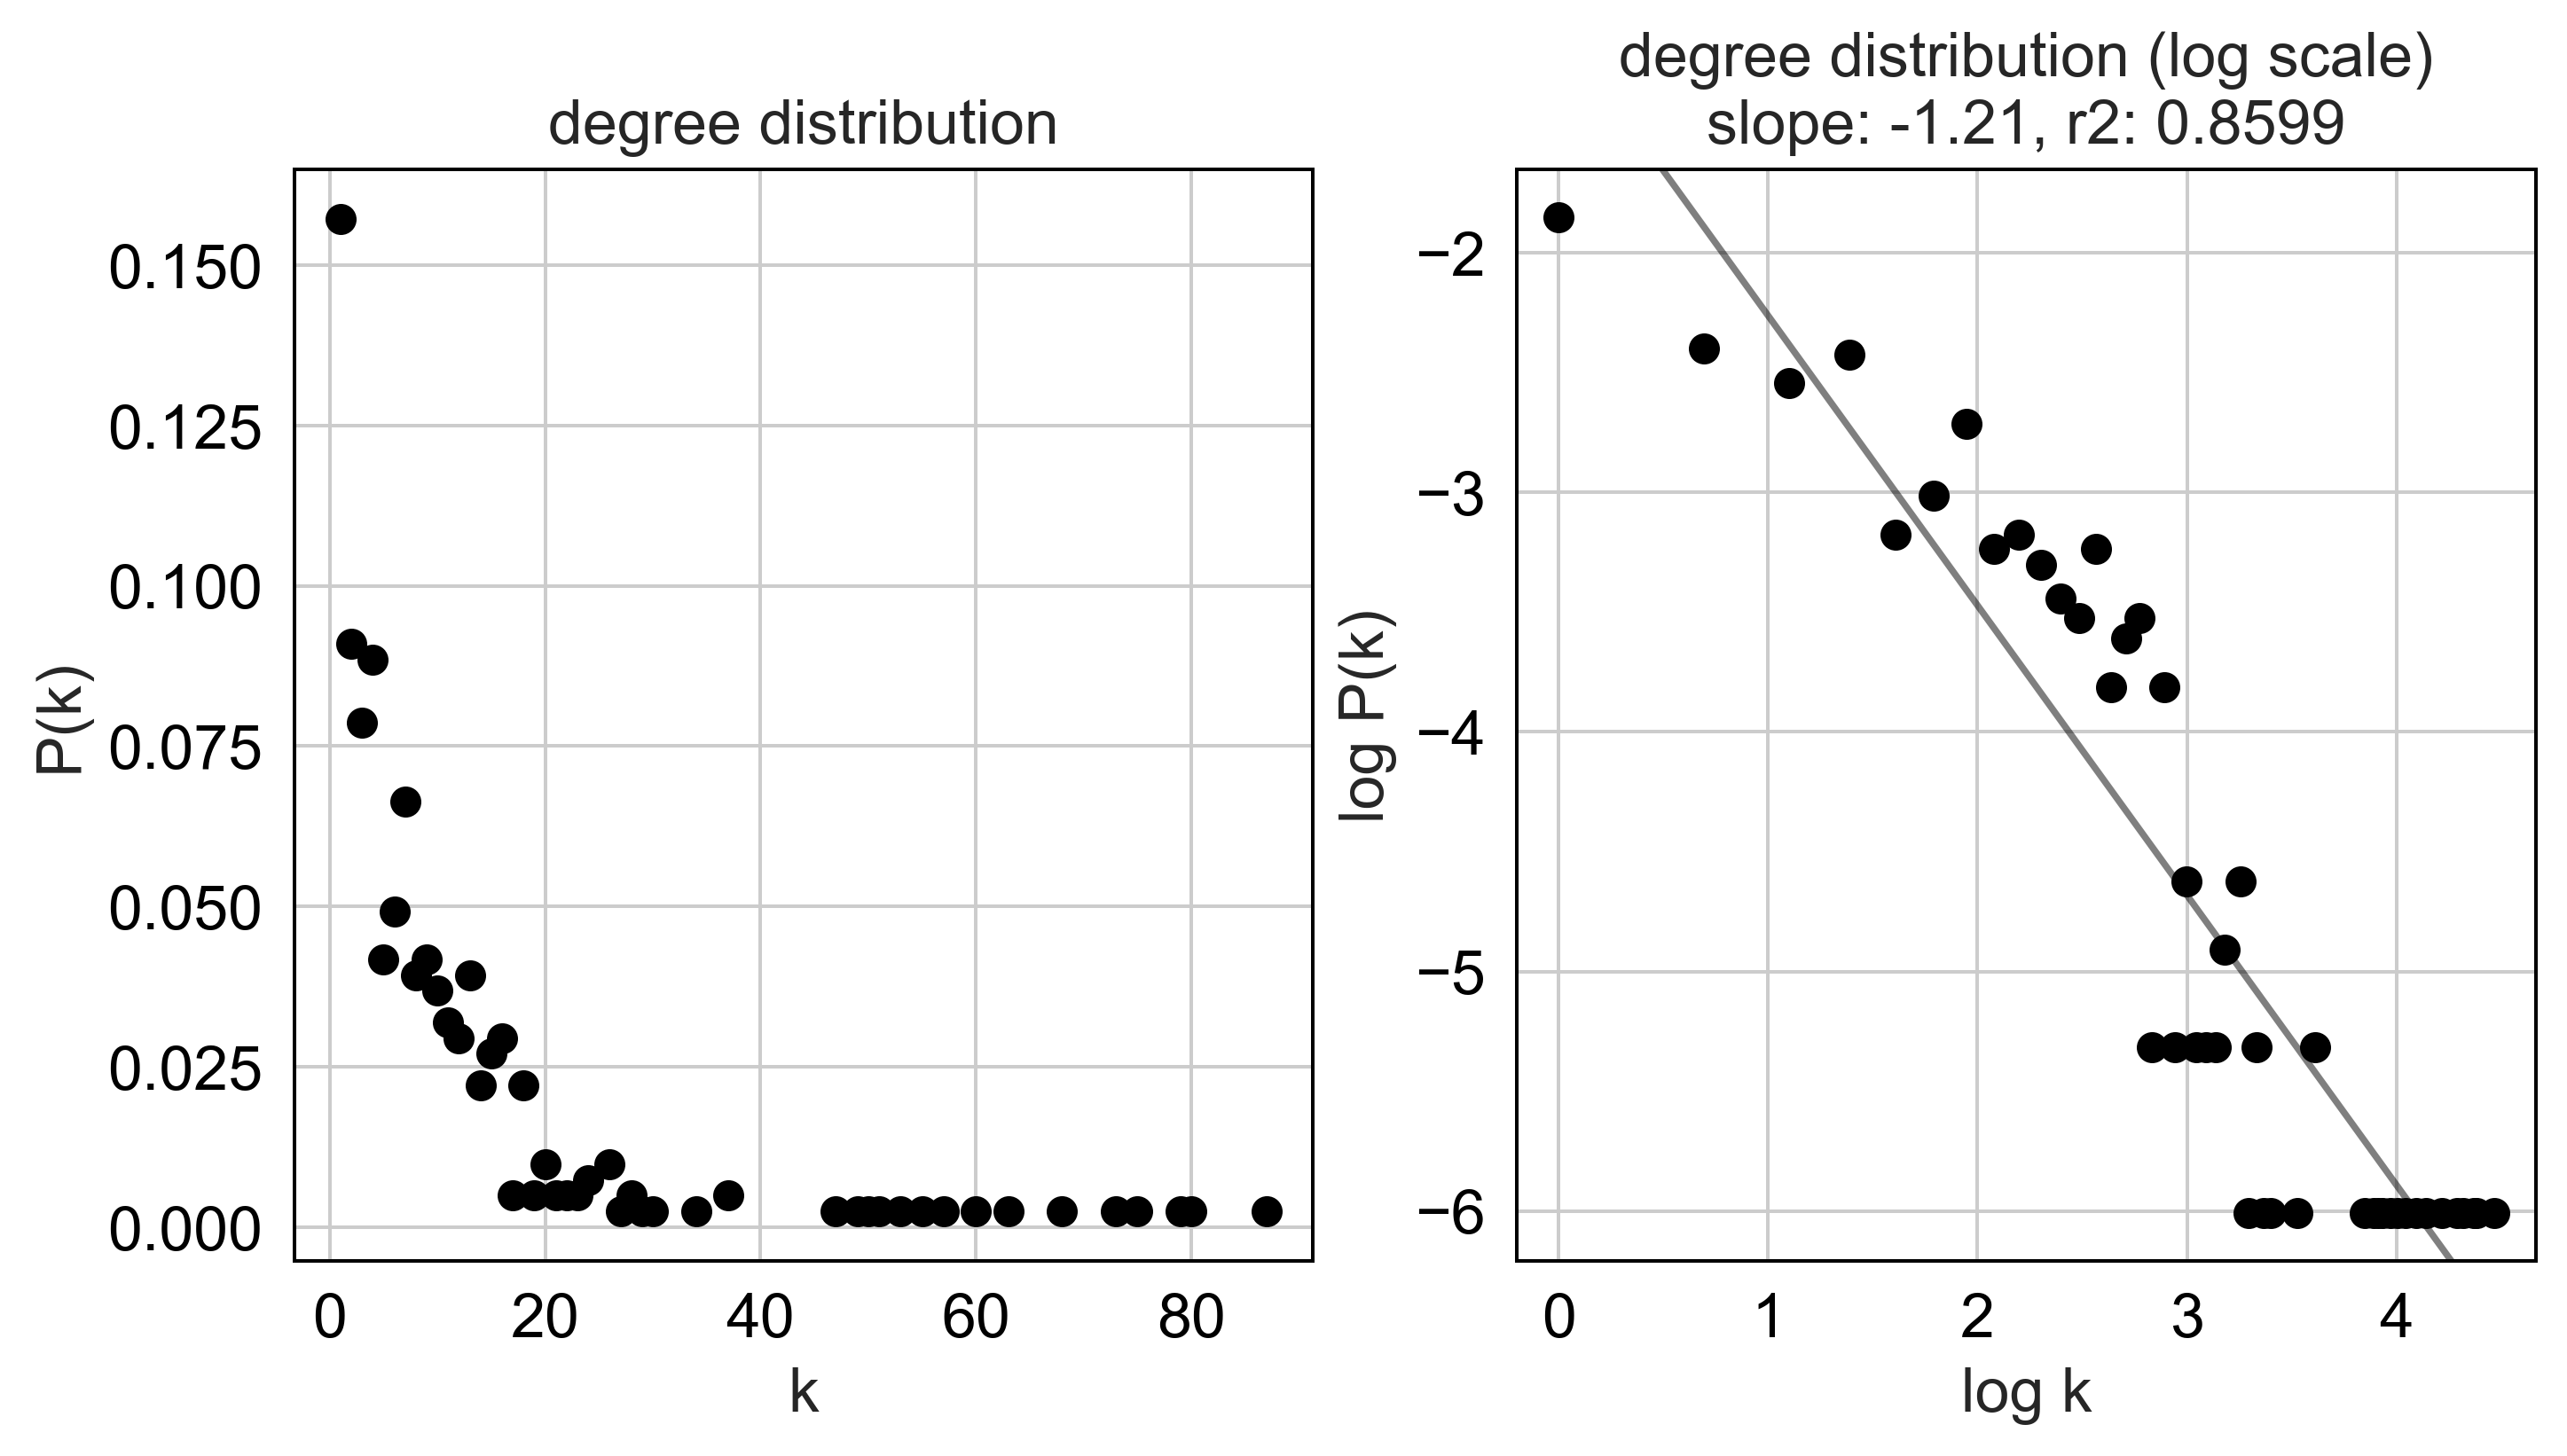

Basal_SERPINE2+


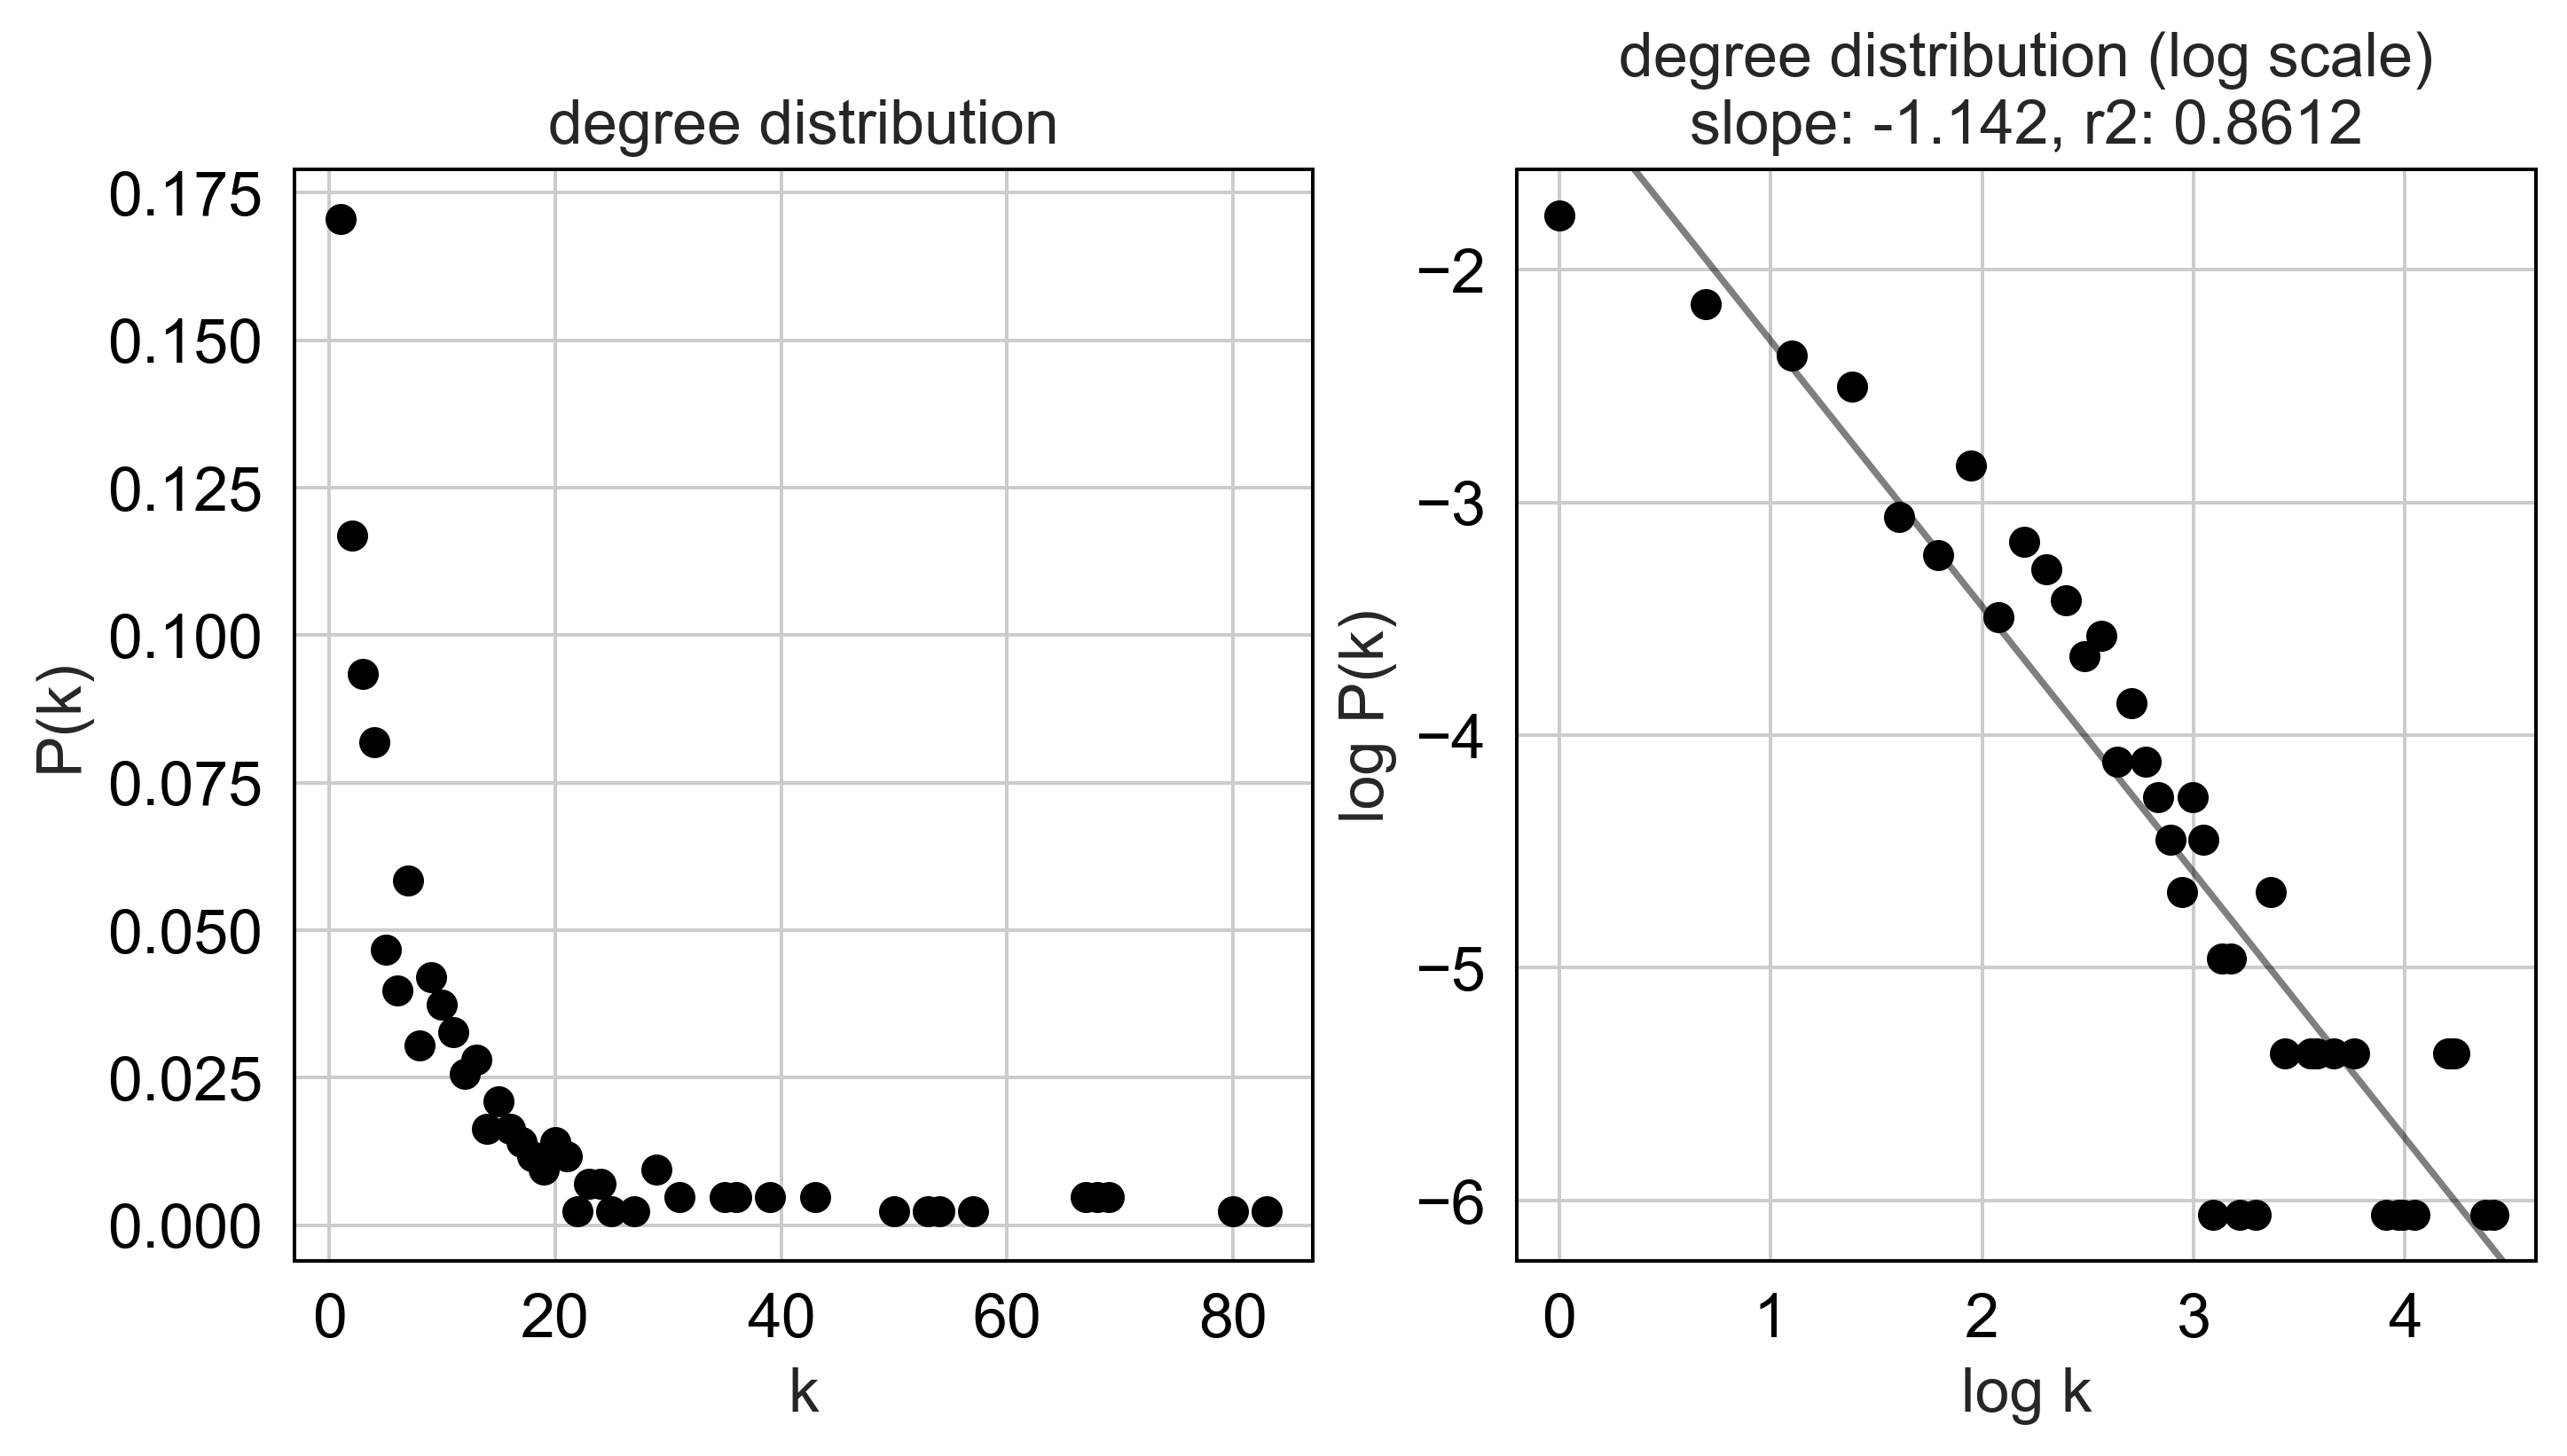

Club_DHRS9+


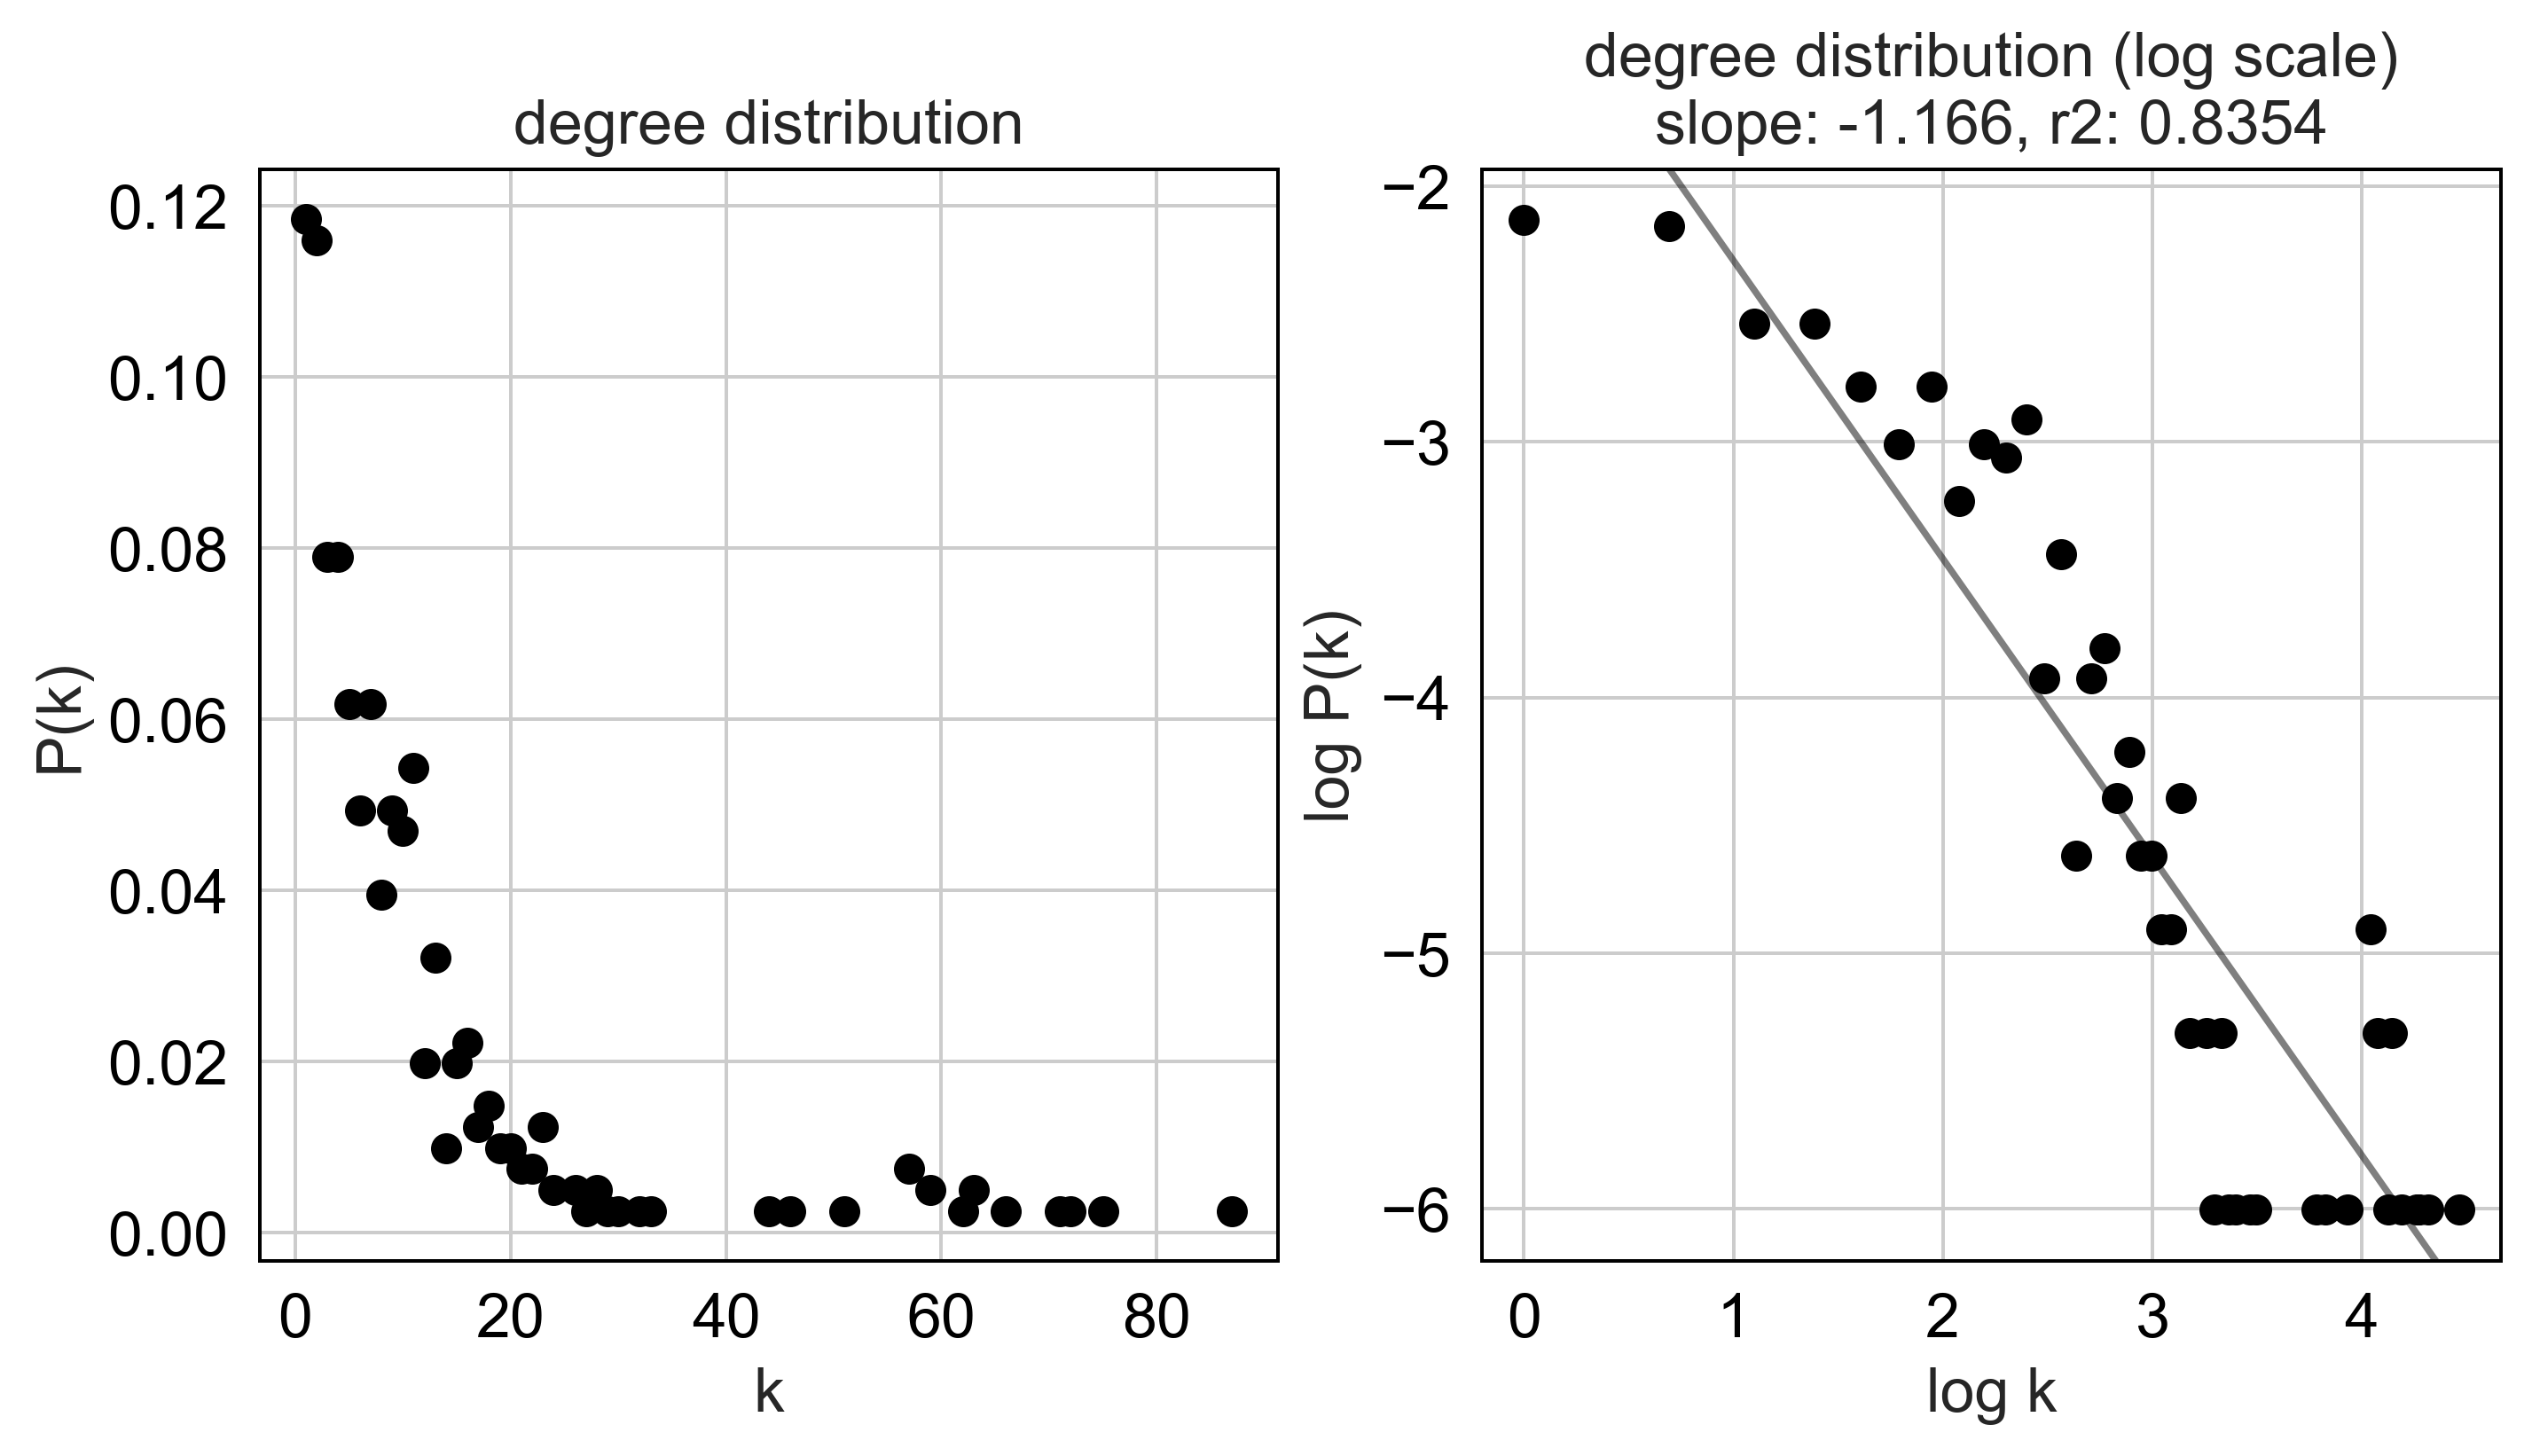

Goblet_RARRES1+


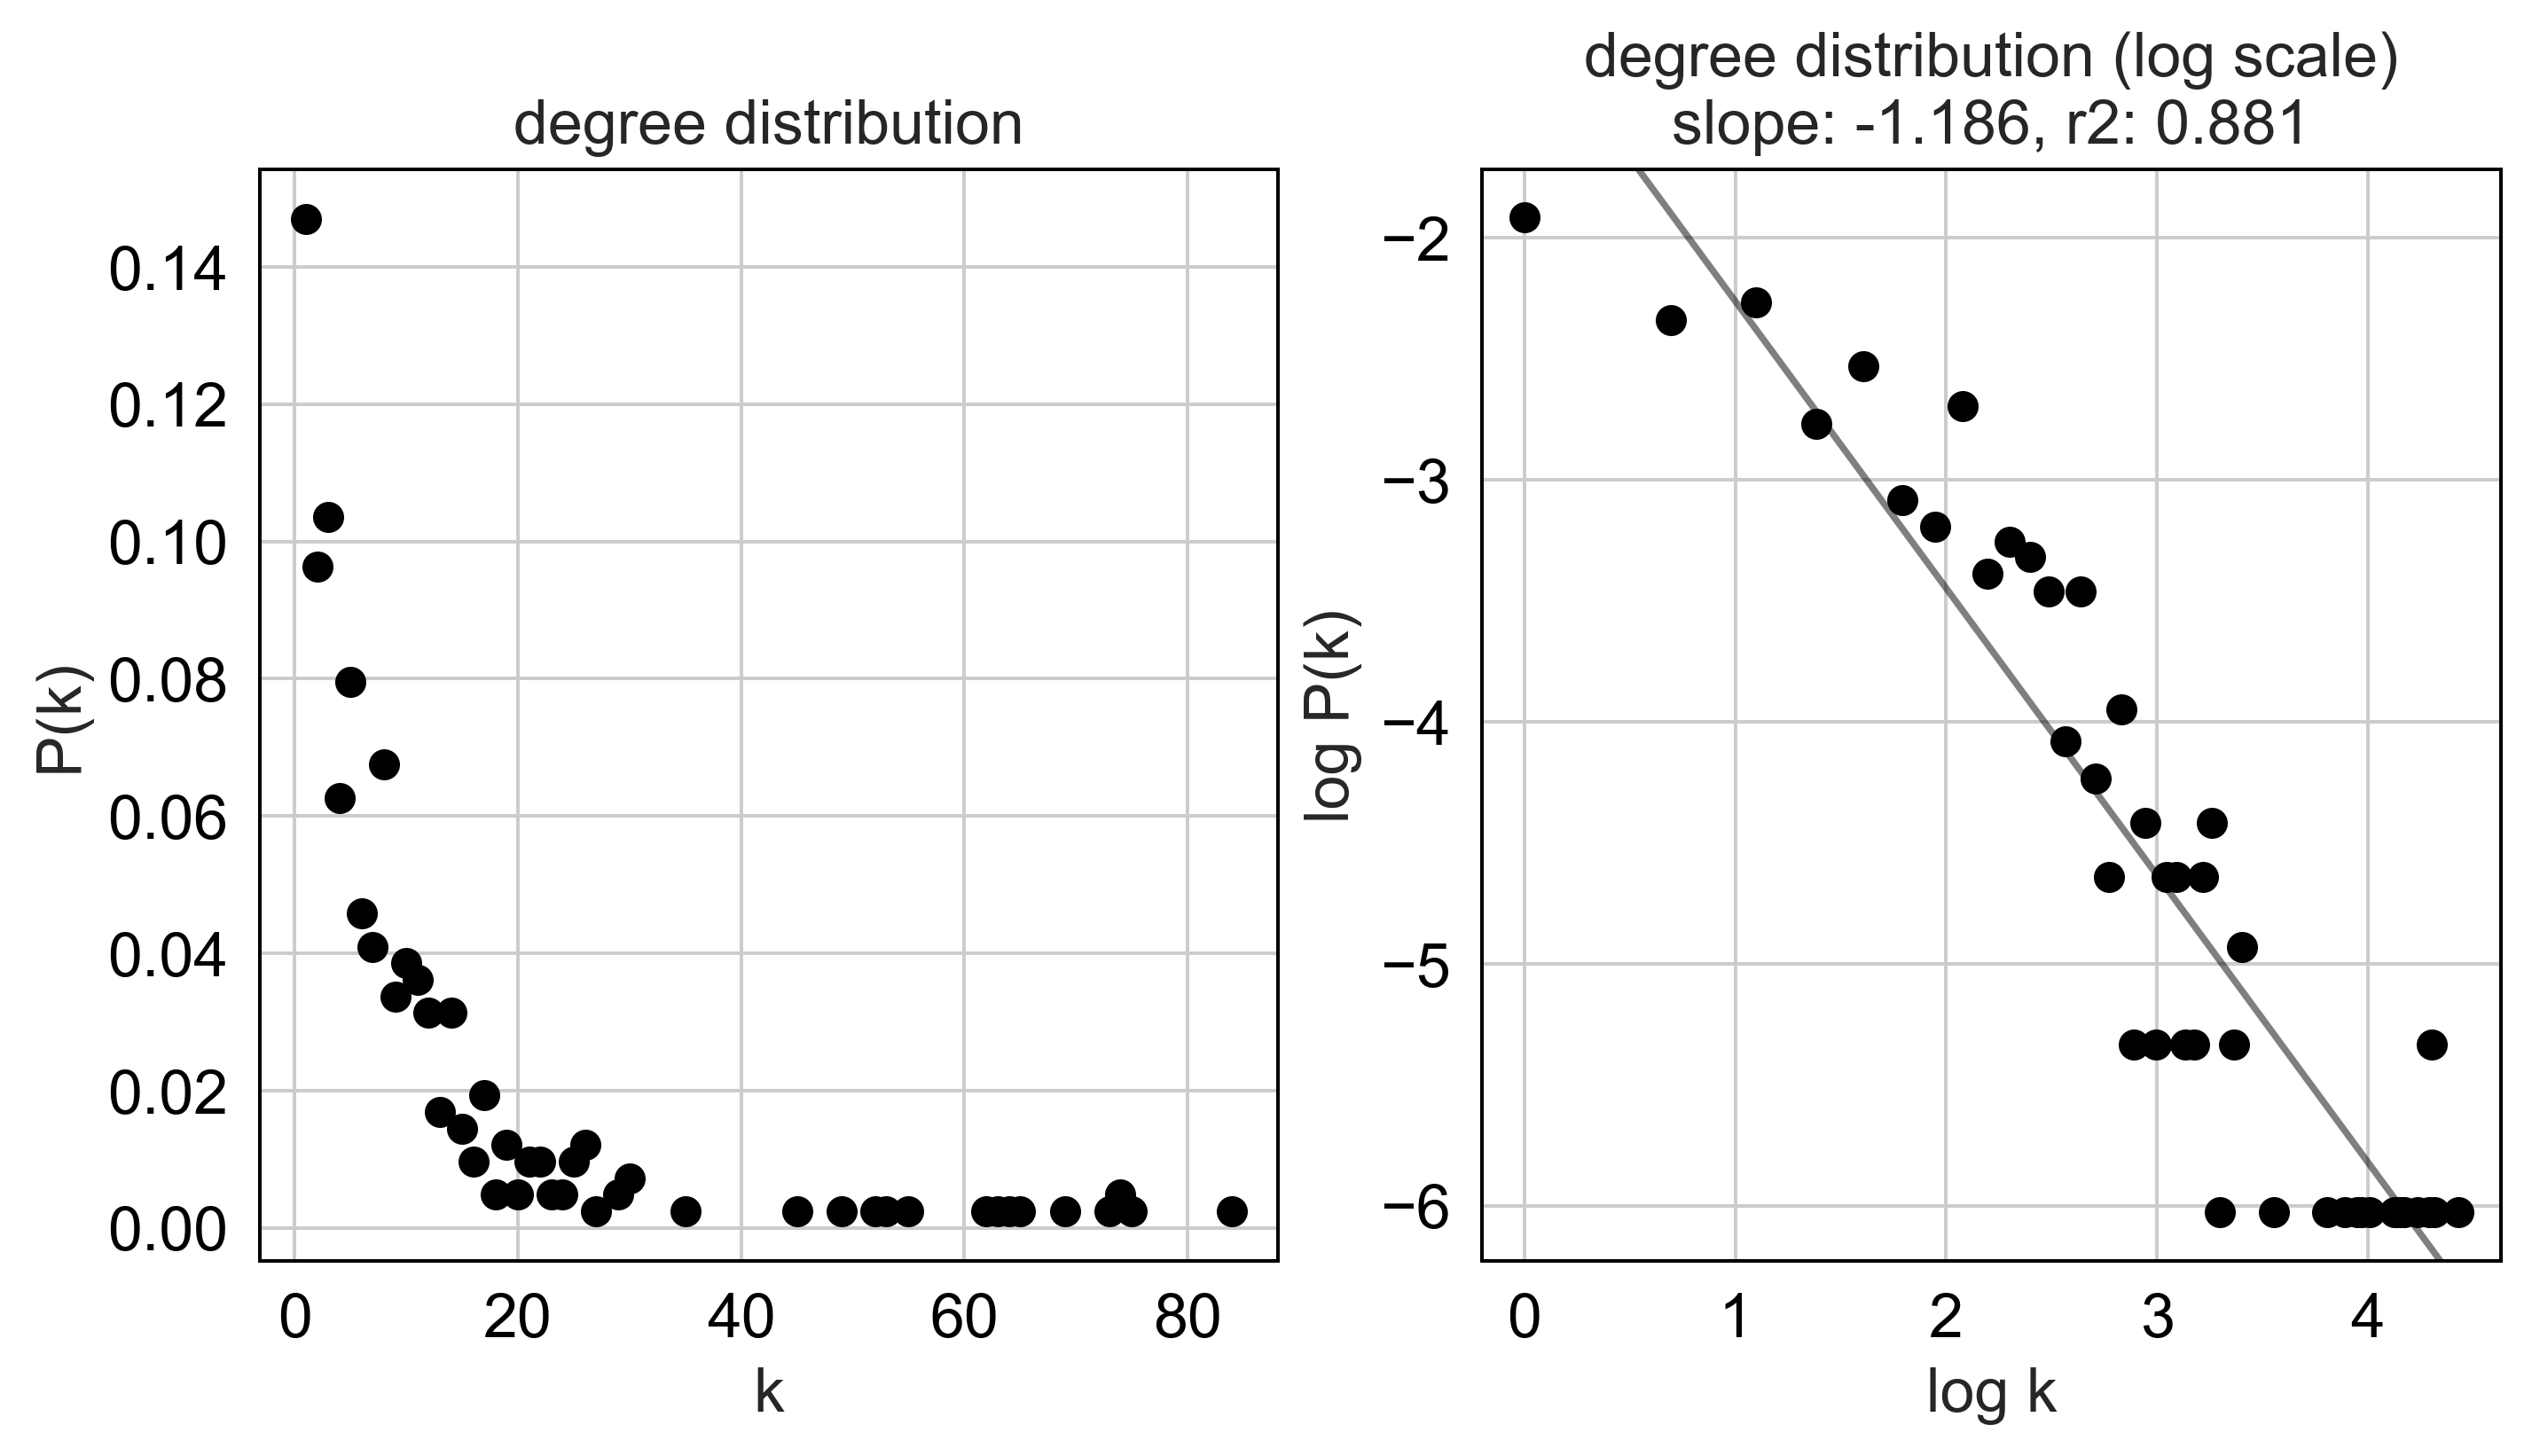

Goblet_STEAP4+


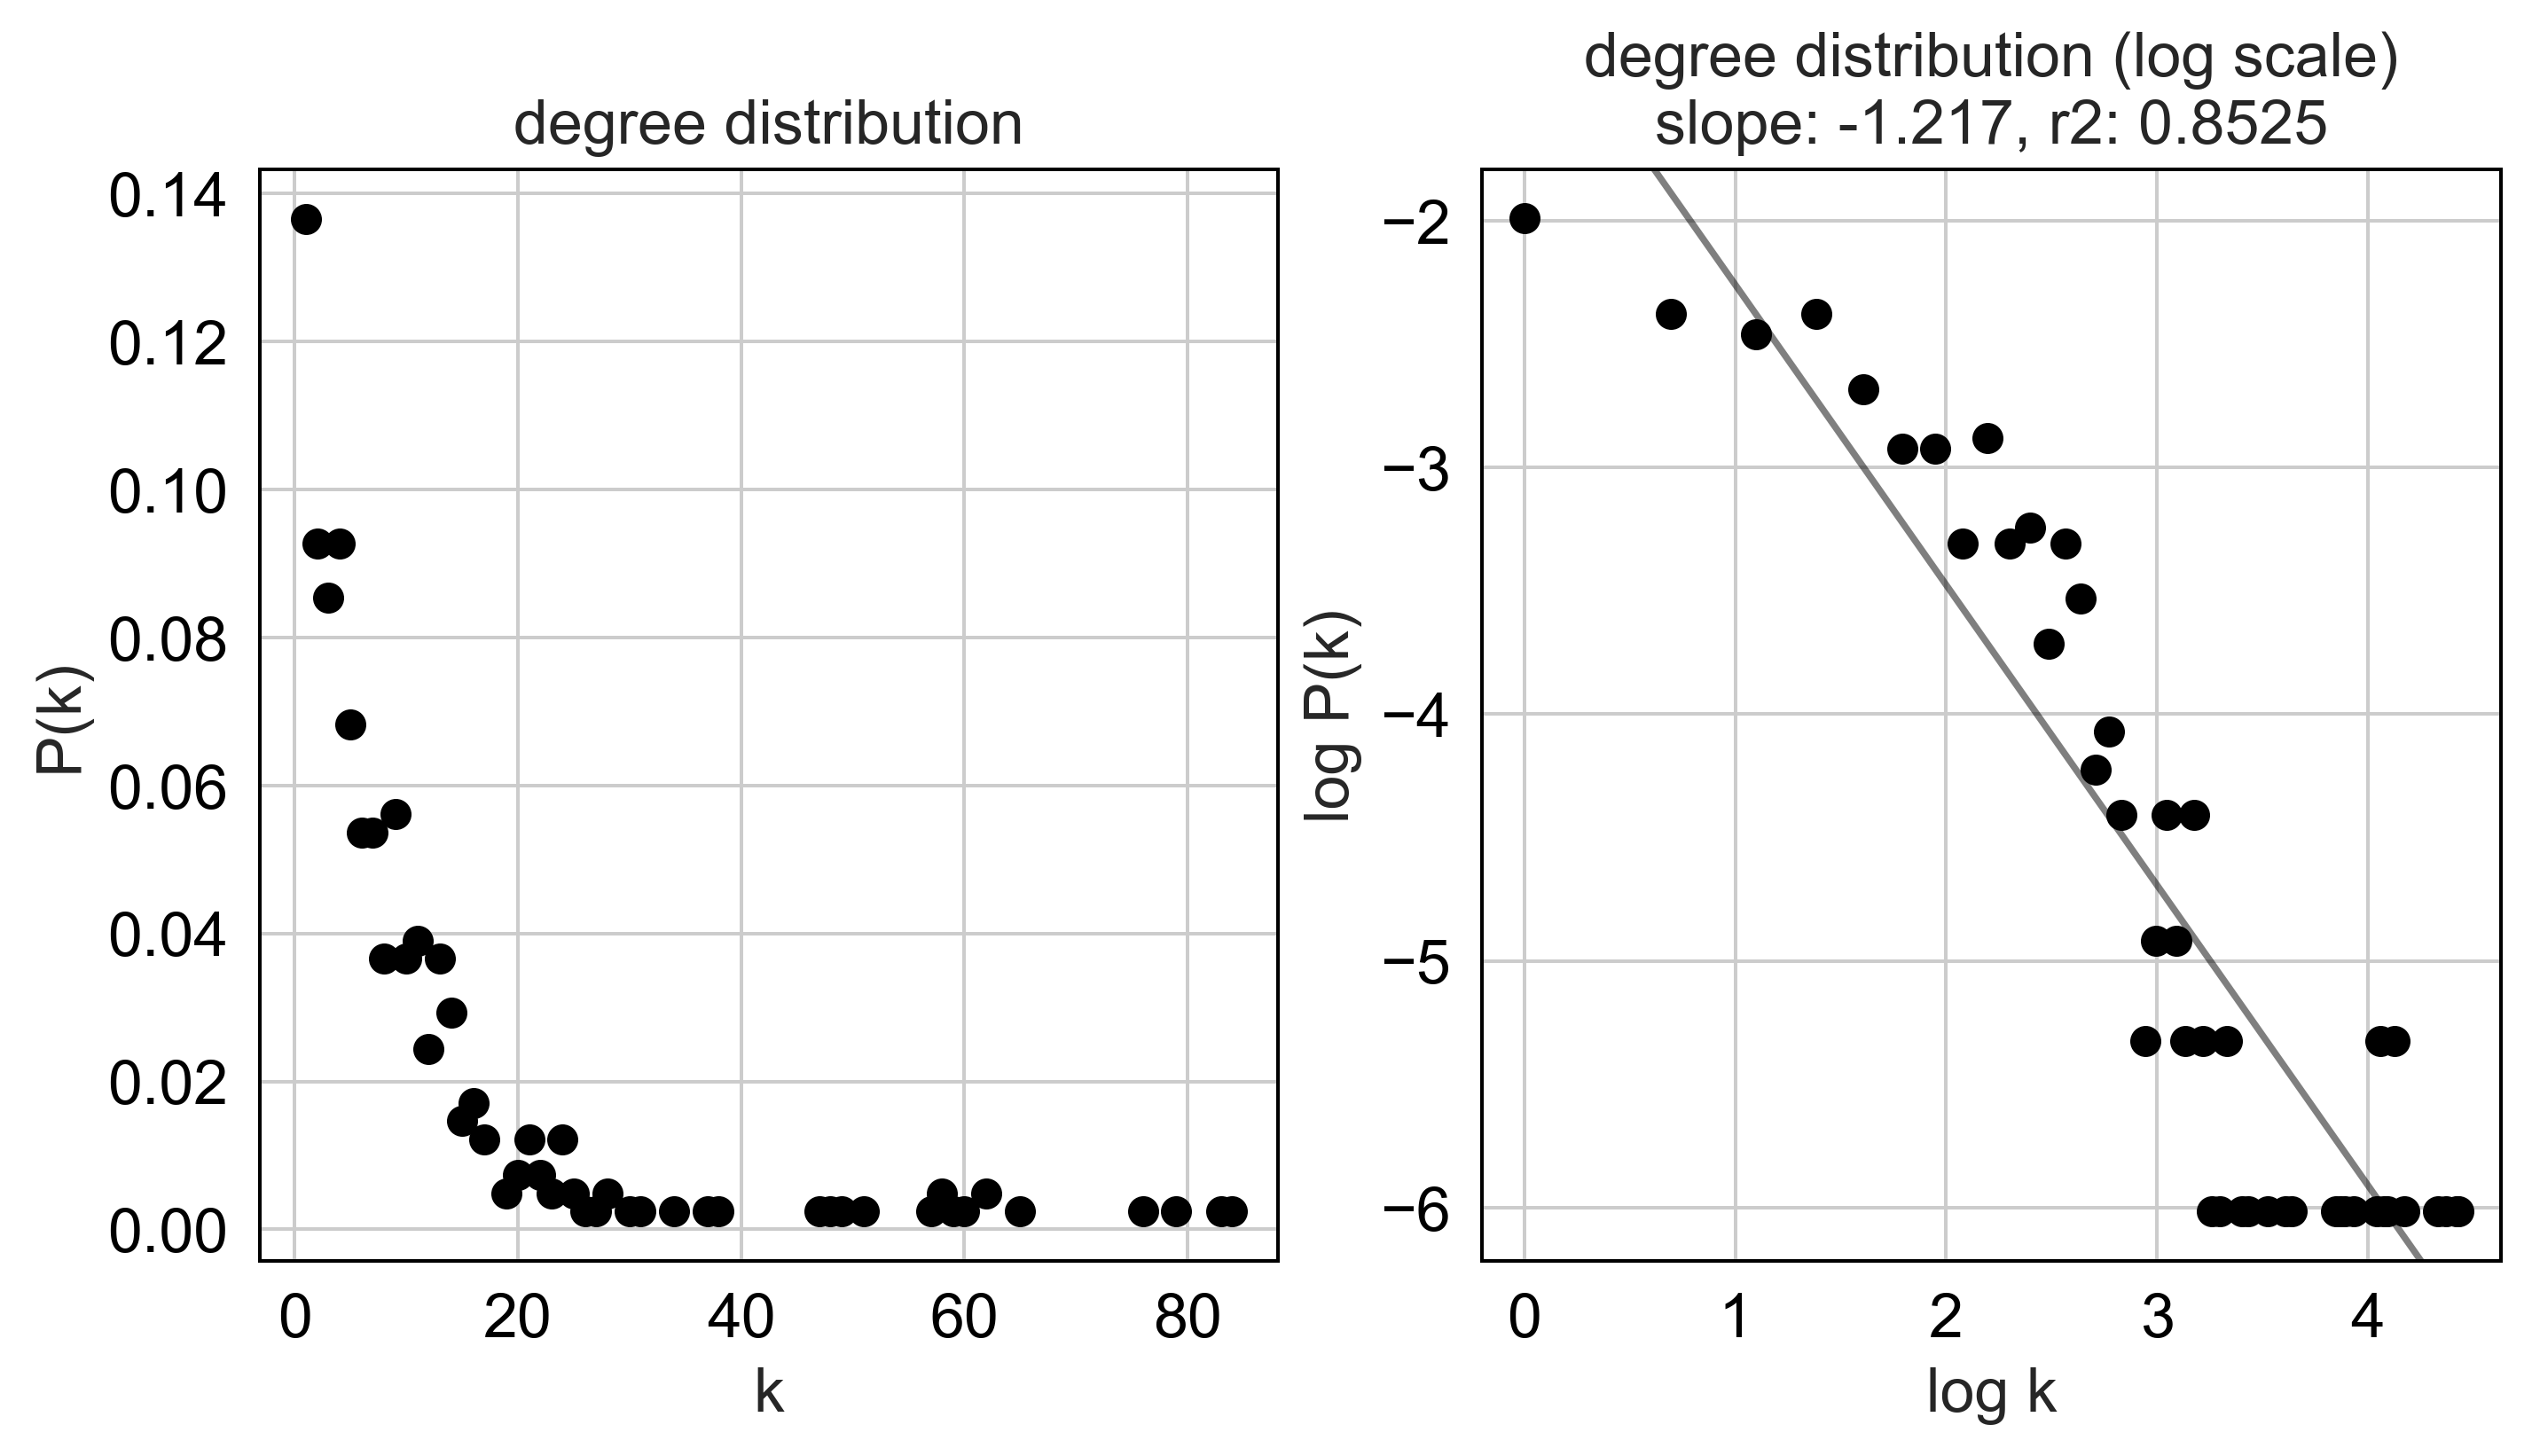

SupraB_KRT16+


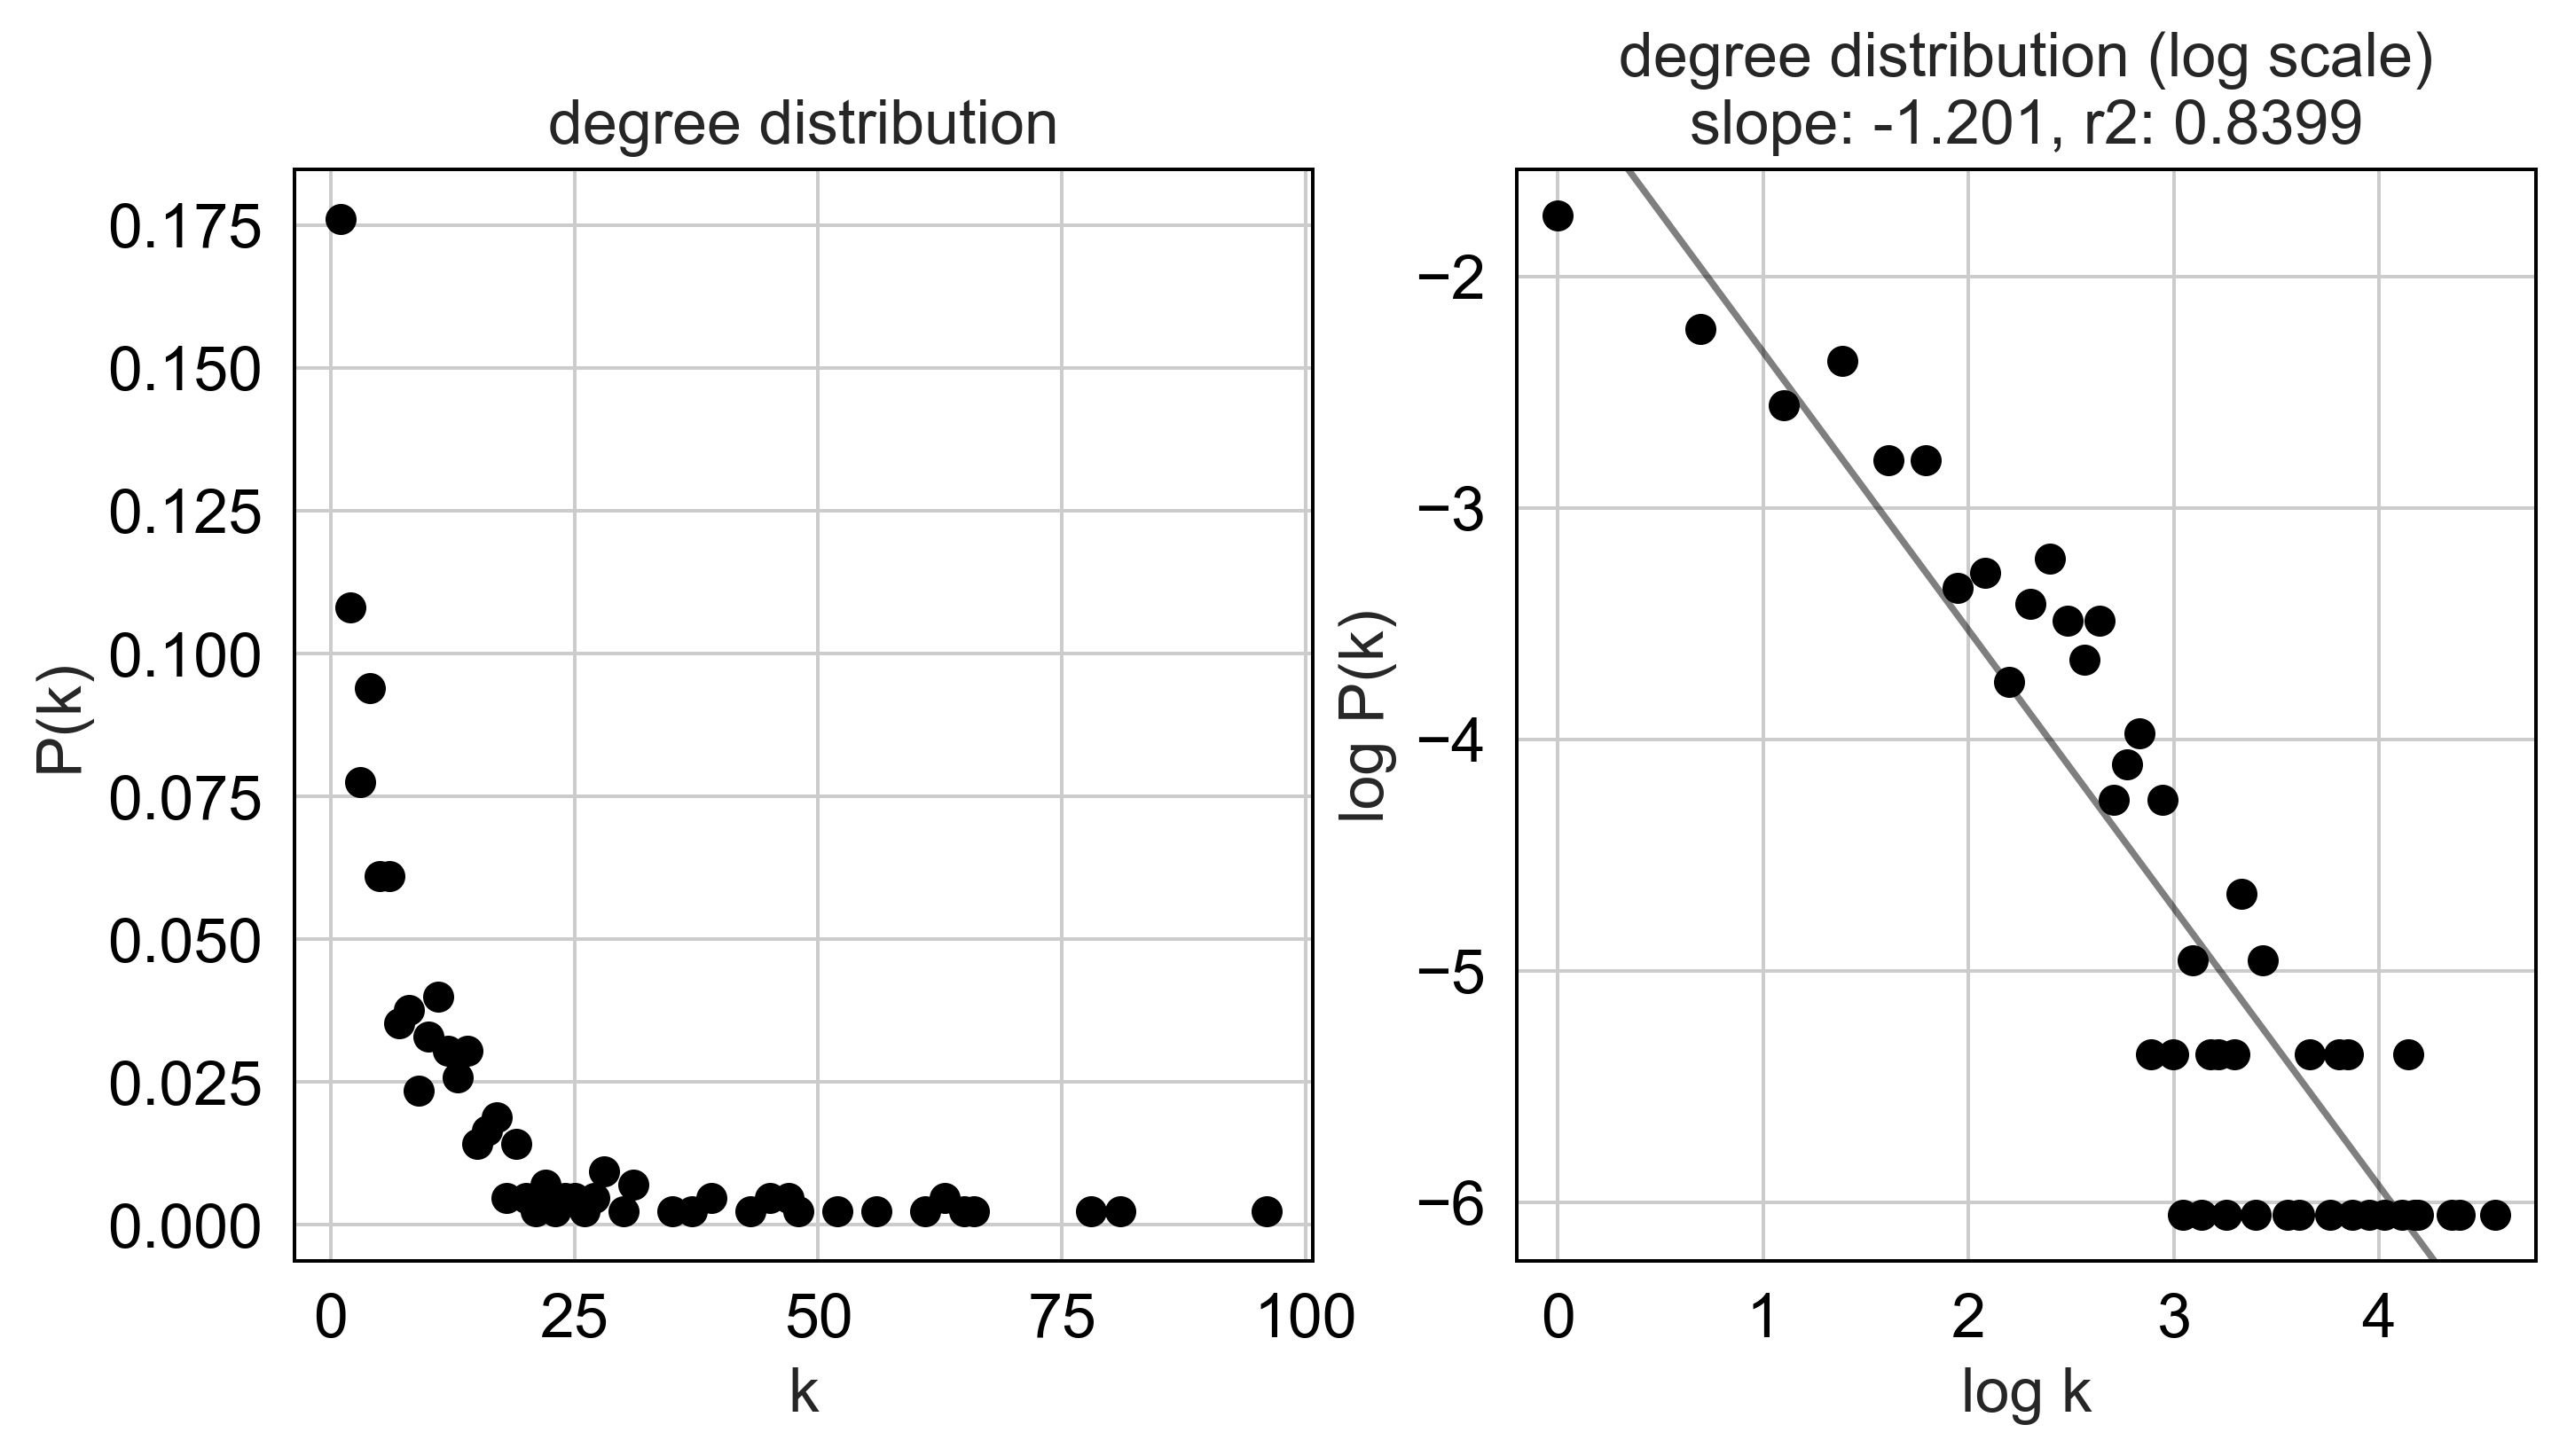

iavAT2_lip


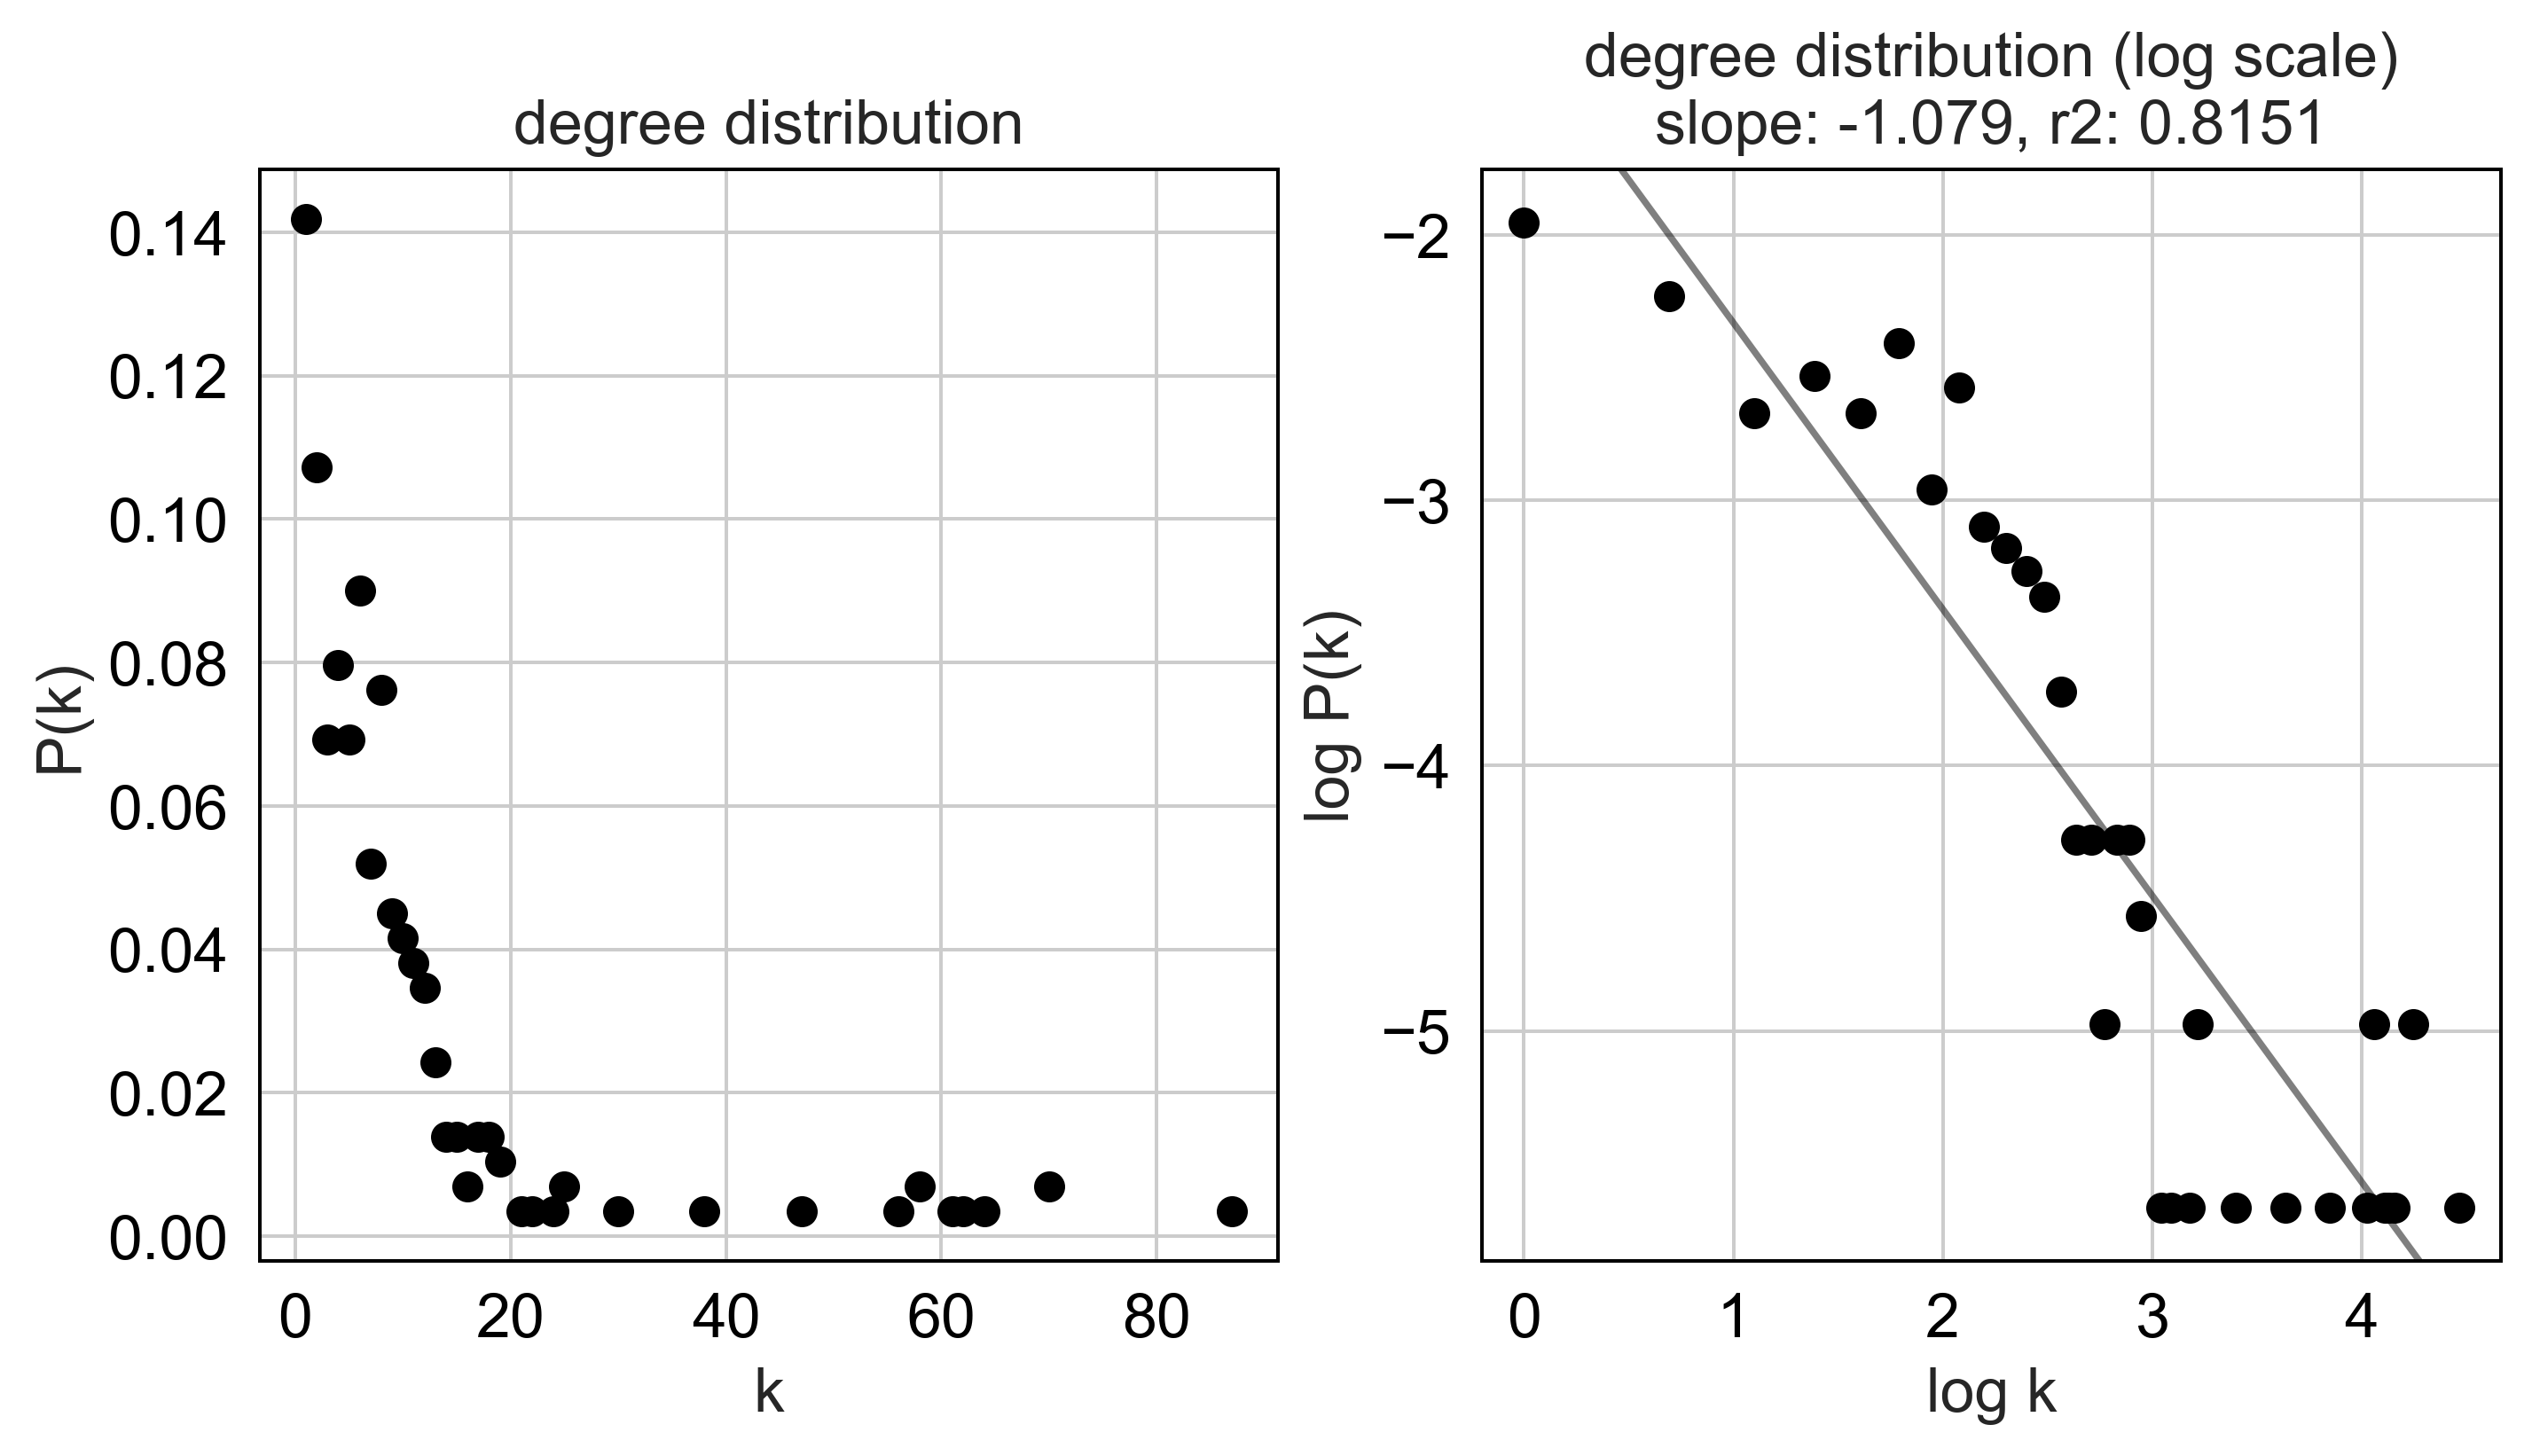

iavClub_SAA1+


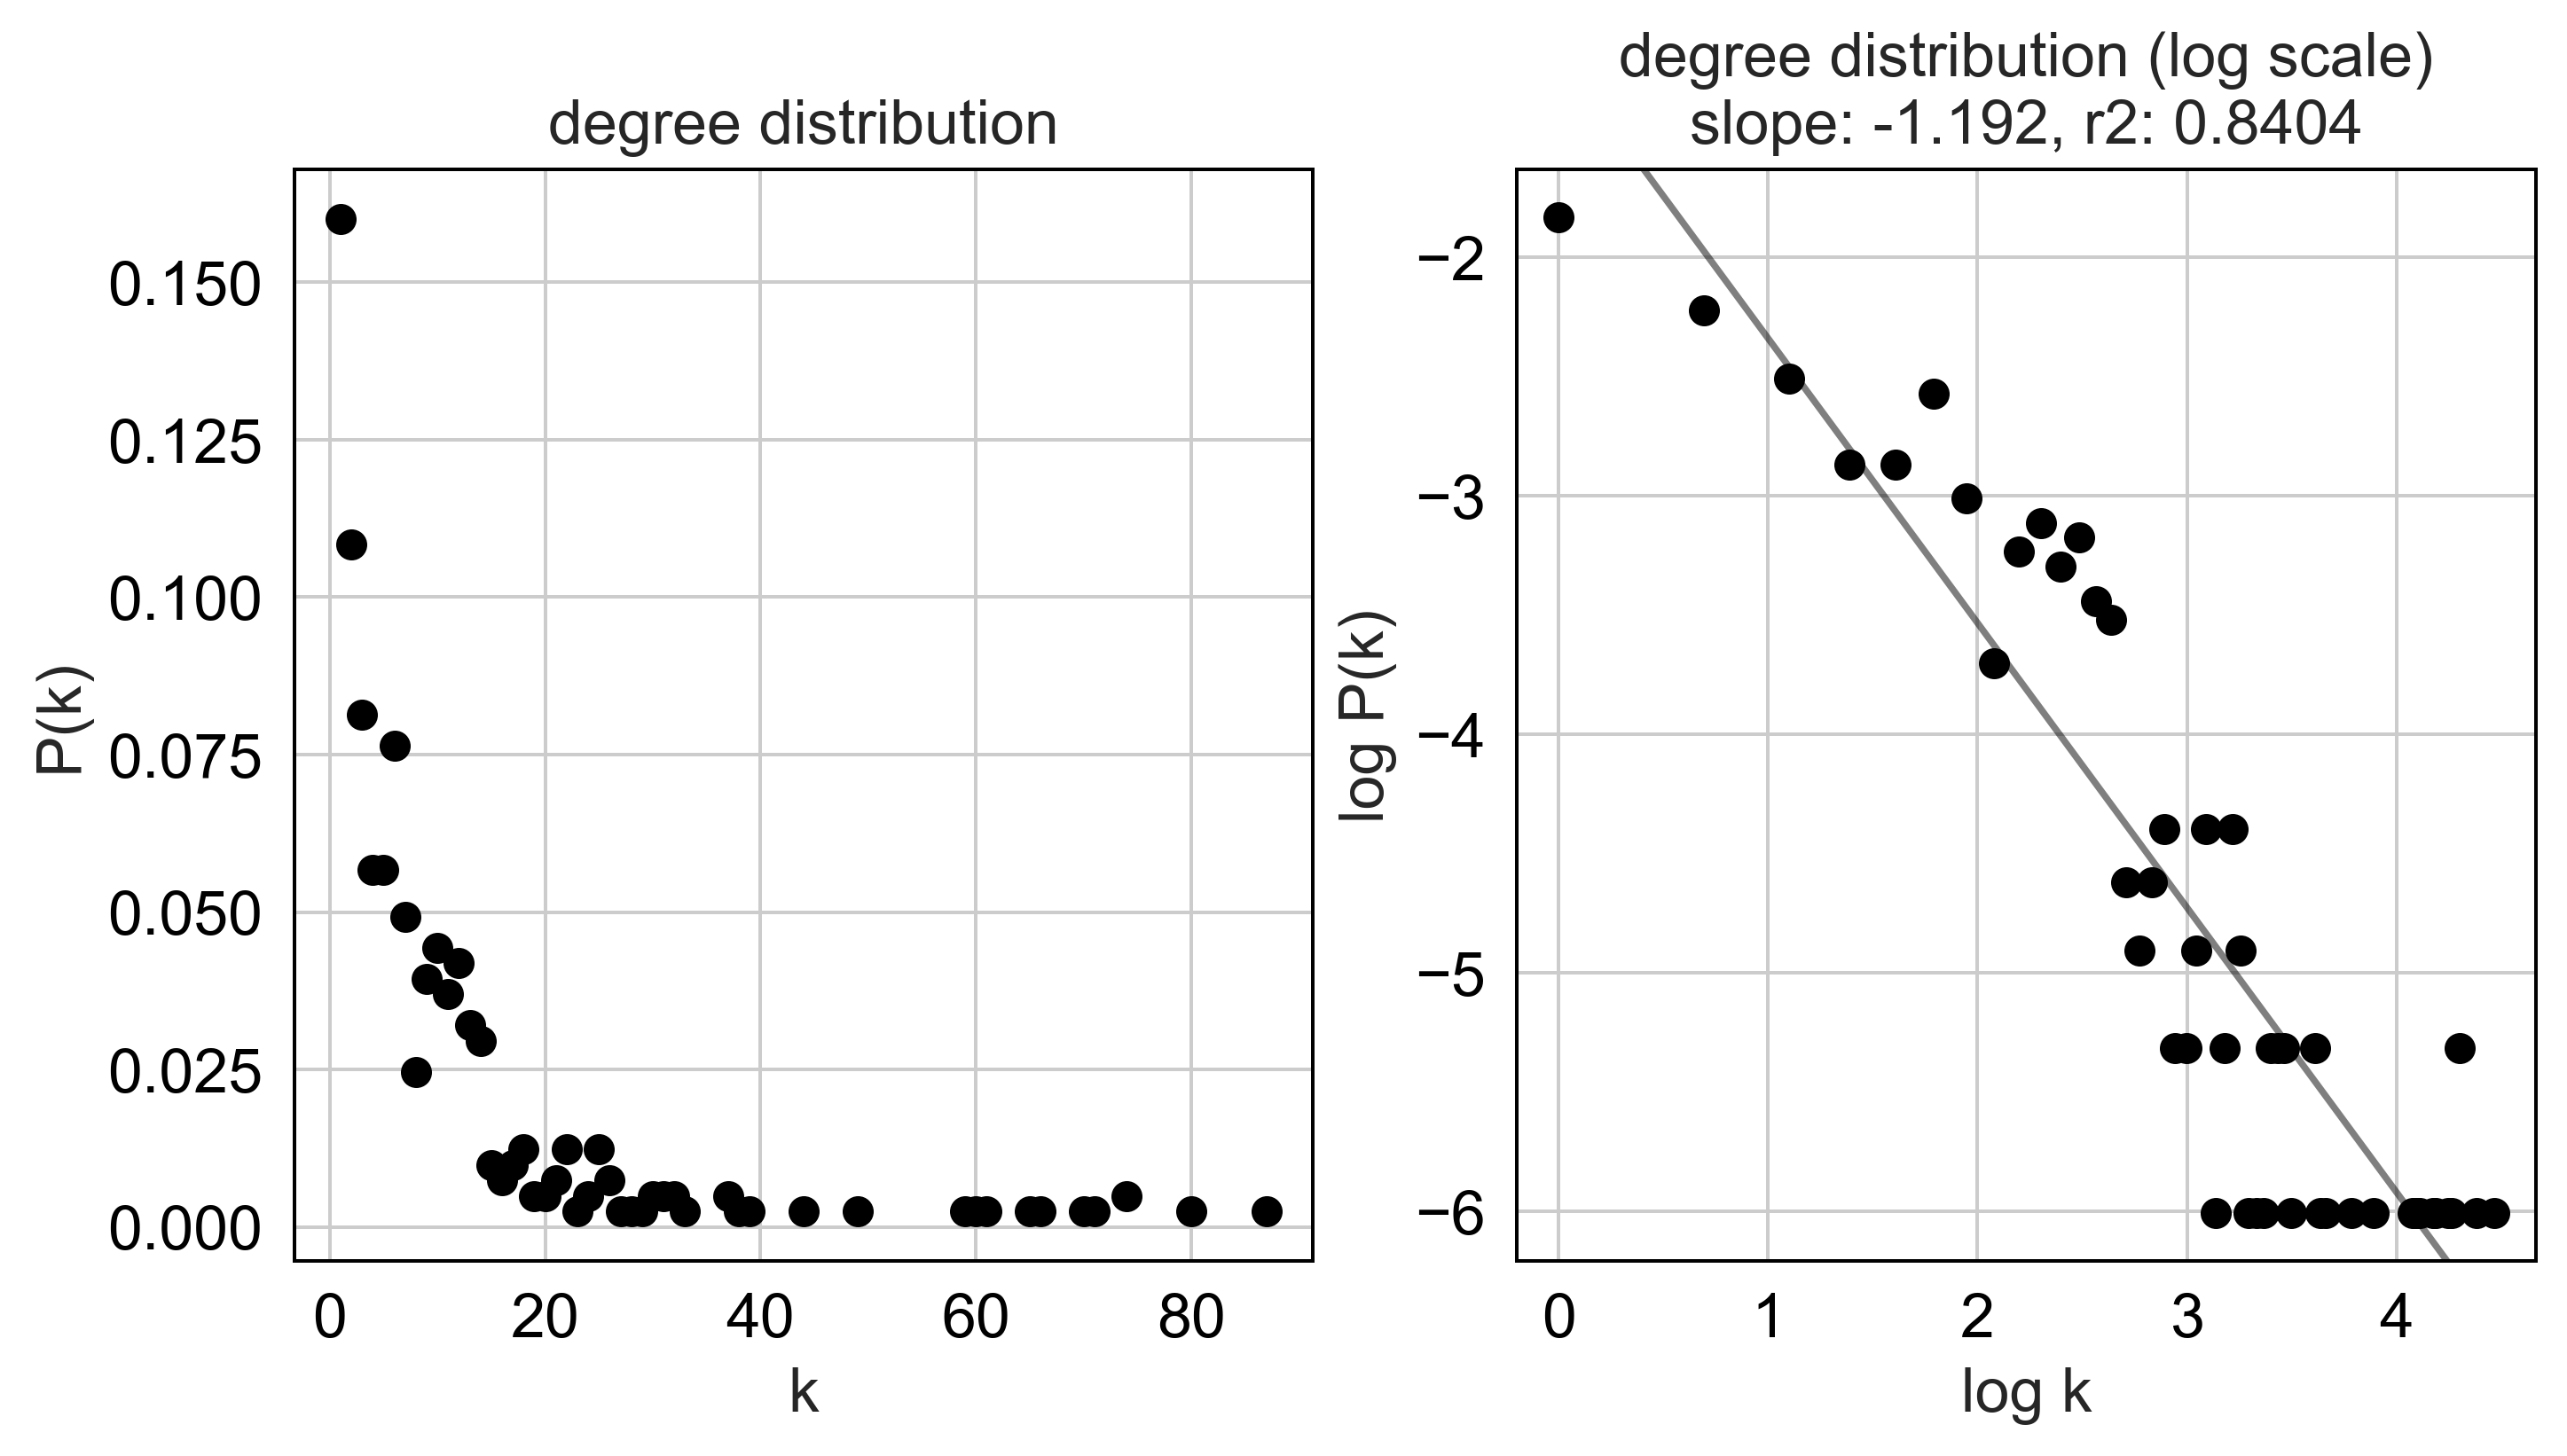

iavEpi


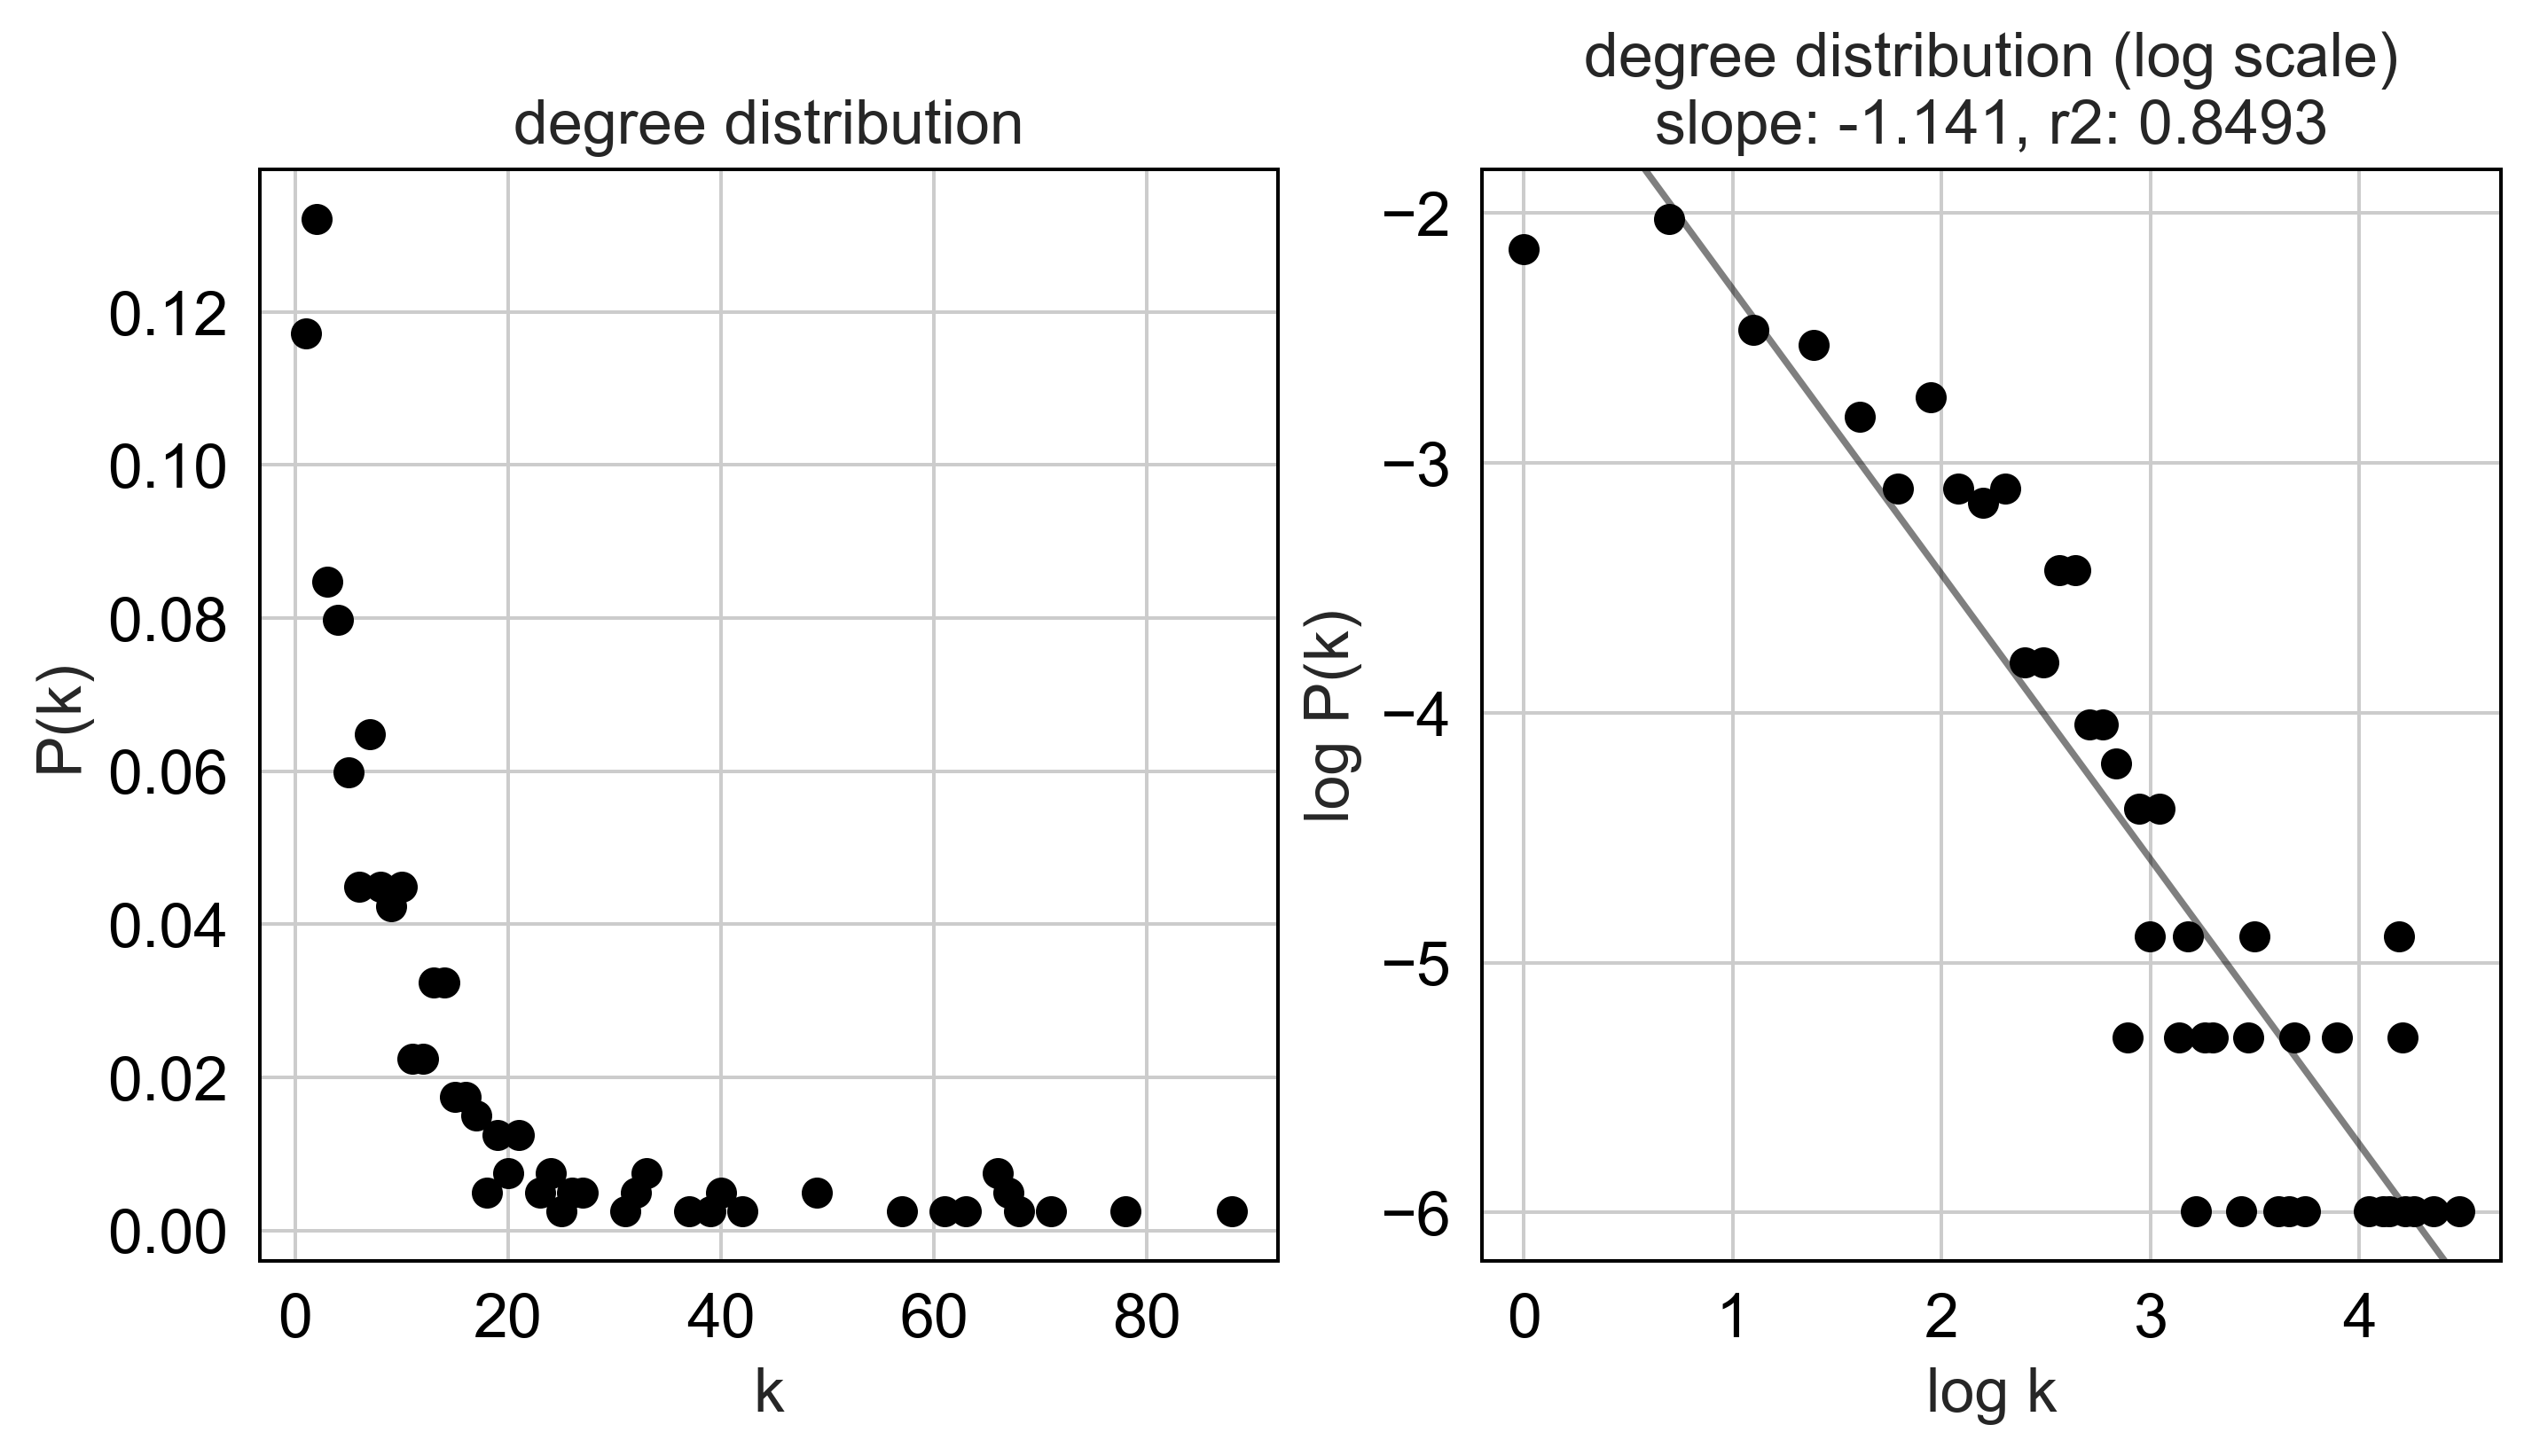

In [29]:
plt.rcParams["figure.figsize"] = [9, 4.5]
links.plot_degree_distributions(plot_model = True,
                                               #save=f"{save_folder}/degree_distribution/",
                                               )

### Calculate several network scores

In [ ]:
links.get_network_score()
links.merged_score.head()

In [ ]:
links.cluster

In [ ]:
plt.rcParams["figure.figsize"] = [8, 8]
links.plot_scores_as_rank(cluster = "Goblet_21", n_gene = 30, save = f"{save_folder}/Goblet_21_COPD-CTRL_ranked_score")

In [ ]:
plt.rcParams["figure.figsize"] = [8, 8]
links.plot_scores_as_rank(cluster = "Goblet_12", n_gene = 30, save = f"{save_folder}/Goblet_12_COPD-CTRL_ranked_score")

In [ ]:
plt.rcParams["figure.figsize"] = [8, 8]
links.plot_scores_as_rank(cluster = "Basal_16", n_gene = 30, save = f"{save_folder}/Basal_16_COPD-CTRL_ranked_score")

In [ ]:
plt.rcParams["figure.figsize"] = [8, 8]
links.plot_scores_as_rank(cluster = "Basal_22", n_gene = 30, save = f"{save_folder}/Basal_22_COPD-CTRL_ranked_score")

### Compare GRN structur between clusters

In [ ]:
links.plot_score_comparison_2D(value = "eigenvector_centrality",
                               cluster1 = "Goblet_12", cluster2 = "Goblet_21",
                               percentile = 98,
                               save = f"{save_folder}/score_comparison")

In [ ]:
links.plot_score_comparison_2D(value = "eigenvector_centrality",
                               cluster1 = "Basal_16", cluster2 = "Basal_22",
                               percentile = 98,
                               save = f"{save_folder}/score_comparison")

In [ ]:
links.plot_score_comparison_2D(value = "betweenness_centrality",
                               cluster1 = "Goblet_12", cluster2 = "Goblet_21",
                               percentile = 98,
                               save = f"{save_folder}/score_comparison")

In [ ]:
links.plot_score_comparison_2D(value = "betweenness_centrality",
                               cluster1 = "Basal_16", cluster2 = "Basal_22",
                               percentile = 98,
                               save = f"{save_folder}/score_comparison")

In [ ]:
links.plot_score_comparison_2D(value = "degree_centrality_all",
                               cluster1 = "Goblet_12", cluster2 = "Goblet_21",
                               percentile = 98, save = f"{save_folder}/score_comparison")

In [ ]:
links.plot_score_comparison_2D(value = "degree_centrality_all",
                               cluster1 = "Basal_16", cluster2 = "Basal_22",
                               percentile = 98, save = f"{save_folder}/score_comparison")

In [ ]:
links.plot_score_per_cluster(goi = "POU2F2", save = f"{save_folder}/network_score_per_gene/")

In [ ]:
cluster_name = "Goblet_13"
filtered_links_df = links.filtered_links[cluster_name]
filtered_links_df.head()